C:\Users\xysti\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\xysti\AppData\Local\Temp\ipykernel_22384\2751617237.py:43: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


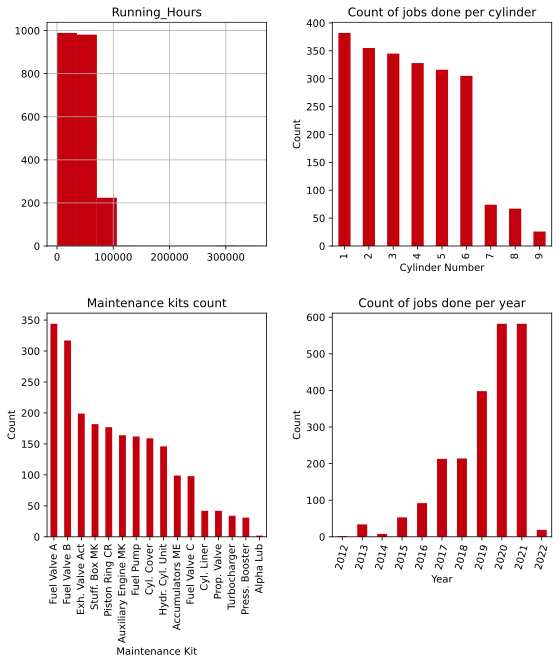

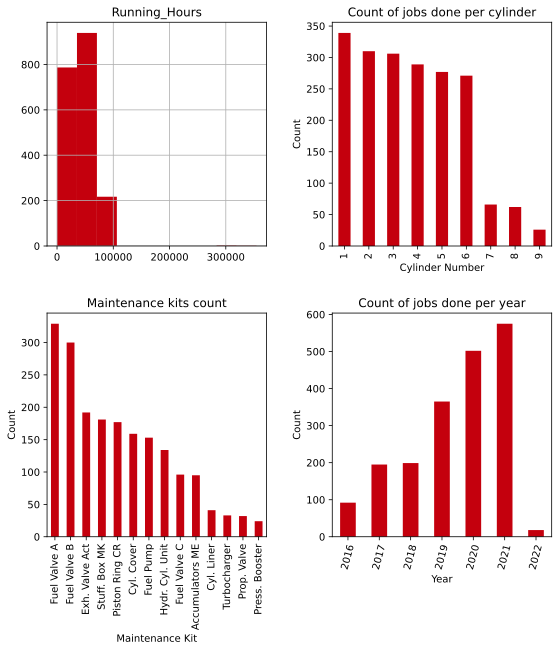

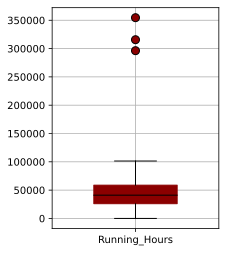

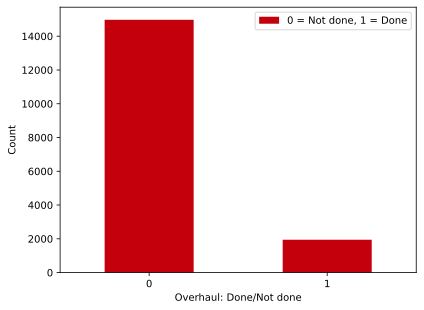

In [1]:
%run "./1_data_preparation.ipynb"

In [2]:
df

Running_Hours  done  Aqua Bonanza  Central  Clamor Schulte  Clover  \
0            47193.0     0             1        0               0       0   
1            47193.0     0             1        0               0       0   
2            47193.0     0             1        0               0       0   
3            47193.0     0             1        0               0       0   
4            47193.0     0             1        0               0       0   
...              ...   ...           ...      ...             ...     ...   
23573        24016.0     0             0        0               0       0   
23574        24016.0     0             0        0               0       0   
23575        24016.0     0             0        0               0       0   
23576        24016.0     0             0        0               0       0   
23577        24016.0     0             0        0               0       0   

       Donata Schulte  Dorothea Schulte  Hans Schulte  Hedwig Schulte  ...  7  \
0                   0                 0             0               0  ...  0   
1                   0                 0             0               0  ...  0   
2                   0                 0             0               0  ...  0   
3                   0                 0             0               0  ...  0   
4                   0                 0             0               0  ...  0   
...               ...               ...           ...             ...  ... ..   
23573               0                 0             0               0  ...  0   
23574               0                 0             0               0  ...  0   
23575               0                 0             0               0  ...  0   
23576               0                 0             0               0  ...  0   
23577               0                 0             0               0  ...  0   

       8  9  2016  2017  2018  2019  2020  2021  2022  
0      0  0     1     0     0     0     0     0     0  
1      0  0     1     0     0     0     0     0     0  
2      0  0     1     0     0     0     0     0     0  
3      0  0     1     0     0     0     0     0     0  
4      0  0     1     0     0     0     0     0     0  
...   .. ..   ...   ...   ...   ...   ...   ...   ...  
23573  0  0     0     0     0     0     0     0     1  
23574  0  0     0     0     0     0     0     0     1  
23575  0  0     0     0     0     0     0     0     1  
23576  0  0     0     0     0     0     0     0     1  
23577  0  0     0     0     0     0     0     0     1  

[16914 rows x 59 columns]

## 10. HYPERPARAMETER TUNING

In [3]:
class_weights = {0:0.12, 1: 0.88}

### 10a. Random Forest

In [22]:
### 1. USE GRIDSEARCH TO FIND BEST PARAMETERS FOR RANDOM FOREST

# define models and parameters
model = RandomForestClassifier(class_weight = 'balanced')
n_estimators = [500, 1000, 1200]   # default: 100, previous try 500
max_features = ['sqrt', 'log2', None]   # default: sqrt
#min_samples_leaf = [1]     # default: 1    # [, 3,  5]  give much worse results
criterion = ['gini', 'entropy']   # default: gini
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,  criterion=criterion) # min_samples_leaf = min_samples_leaf,
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best f1 score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best f1 score: 0.673843 using {'criterion': 'entropy', 'max_features': None, 'n_estimators': 1000}
0.575289 (0.046927) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 500}
0.576634 (0.044492) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}
0.578756 (0.046031) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1200}
0.520620 (0.045625) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 500}
0.524269 (0.045541) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
0.520499 (0.043980) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1200}
0.671801 (0.037959) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 500}
0.672280 (0.040514) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 1000}
0.671436 (0.039889) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 1200}
0.584625 (0.043344) with: {'criterion': 'entropy', 'max_features

The hyperparmeters are tested in validation set, which is subset of the training set. This is why f1 scores are not trustworthy. Best hyperparameters are used to fit the model to the test set; we expect to get a score at least equal to the not tuned model.

In [4]:
### 2. USE BEST PARAMETERS TO MAKE PREDICTIONS ON THE TEST SET 
#Best f1 score: 0.673 using {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 1000}
RFC_3 = RandomForestClassifier(n_estimators=1000, max_features=None, criterion='entropy', class_weight = 'balanced')   # class_weight = {0:0.15, 1: 0.85} doesn't make difference
RFC_3.fit(X_train,y_train)
y_pred_RFC_3 = RFC_3.predict(X_test)
probs_RFC_3 = RFC_3.predict_proba(X_test)

ScoreRFC_3 = metrics.f1_score(y_test, y_pred_RFC_3)
cmRFC_3 = metrics.confusion_matrix(y_test, y_pred_RFC_3)
metricsRFC_3 = metrics.classification_report(y_test, y_pred_RFC_3)

In [5]:
probs_RFC_3 = probs_RFC_3[:, 1]

In [6]:
precision_RFC_3, recall_RFC_3, threshold_RFC_3 = precision_recall_curve(y_test, probs_RFC_3)
fscore_RFC_3 = (2 * precision_RFC_3 * recall_RFC_3) / (precision_RFC_3 + recall_RFC_3)
ix_RFC_3 = nanargmax(fscore_RFC_3)
auc_RFC_3 = auc(recall_RFC_3, precision_RFC_3)

In [7]:
# F1 Score and corresponding Threshold
print('Random Forest with weighted classes Best Threshold=%f, F-Score=%.3f' % (threshold_RFC_3[ix_RFC_3], fscore_RFC_3[ix_RFC_3]))

Random Forest with weighted classes Best Threshold=0.378000, F-Score=0.746


In [8]:
y_pred = (probs_RFC_3 > threshold_RFC_3[ix_RFC_3]).astype('float')
confusion_matrix(y_test, y_pred)

array([[3575,  163],
       [ 104,  387]], dtype=int64)

### 10b. XG Boost

In [29]:
### 1. USE GRIDSEARCH TO FIND BEST PARAMETERS FOR XG BOOST
model = xgb.XGBClassifier(objective="binary:logistic")
n_estimators = [500, 1000, 1500]         # default: 100, used: 500  (100, 1000, 2000)
learning_rate = [0.001, 0.1, 0.3]        # default: 0.3  (try 0.001, 0.3, 0.9)
subsample = [0.5, 0.75, 1.0]             # default: 1 (max = 1)
max_depth = [3, 6, 9]                   # default: 6    (try 6,9,15)
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[21:25:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.692853 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}
0.312018 (0.010228) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}
0.299487 (0.011312) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.75}
0.293972 (0.011648) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
0.342309 (0.015890) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
0.341081 (0.014797) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.75}
0.339624 (0.011554) with: {'learning_ra

In [9]:
### 2. USE BEST PARAMETERS TO MAKE PREDICTIONS ON THE TEST SET
#Best: 0.678828 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}
XGB_3 = xgb.XGBClassifier(objective="binary:logistic", learning_rate = 0.1, max_depth = 9, n_estimators = 1000, subsample=1) 
XGB_3.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))
y_pred_XGB_3 = XGB_3.predict(X_test)
probs_XGB_3 = XGB_3.predict_proba(X_test)

ScoreXGB_3 = metrics.f1_score(y_test, y_pred_XGB_3)
cmXGB_3 = metrics.confusion_matrix(y_test, y_pred_XGB_3)
metricsXGB_3 = metrics.classification_report(y_test, y_pred_XGB_3)

[20:48:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
probs_XGB_3 = probs_XGB_3[:, 1]
precision_XGB_3, recall_XGB_3, threshold_XGB_3 = precision_recall_curve(y_test, probs_XGB_3)
fscore_XGB_3 = (2 * precision_XGB_3 * recall_XGB_3) / (precision_XGB_3 + recall_XGB_3)
ix_XGB_3 = nanargmax(fscore_XGB_3)
auc_XGB_3 = auc(recall_XGB_3, precision_XGB_3)

In [11]:
# F1 Score and corresponding Threshold
print('XG Boost with weighted classes Best Threshold=%f, F-Score=%.3f' % (threshold_XGB_3[ix_XGB_3], fscore_XGB_3[ix_XGB_3]))

XG Boost with weighted classes Best Threshold=0.572478, F-Score=0.712


In [12]:
y_pred = (probs_XGB_3 > threshold_XGB_3[ix_XGB_3]).astype('float')
confusion_matrix(y_test, y_pred)

array([[3574,  164],
       [ 130,  361]], dtype=int64)

### 10c. Neural Network

In [13]:
### 1. USE GRIDSEARCH TO FIND BEST PARAMETERS FOR NEURAL NETWORK
# SET INPUT/OUTPUT
Y = y_train
X = X_train


# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

In [14]:
### 2. THE MODEL
def create_model():
    model = Sequential()
    model.add(Dense(500, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
    model.add(Dense(300, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [26]:
### 3. GRIDSEARCH
# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", 
                        optimizer="Adam", 
                        epochs=40, 
                        metrics=['accuracy'],
                        class_weight = class_weights,
                        verbose=1)


# define the grid search parameters
learn_rate = [0.001, 0.01, 0.3]  # default: 0.001
beta_1 = [0.5, 0.8, 0.9]         # default: 0.9
batch_size = [32, 64, 128]        # previous: 64
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__beta_1 = beta_1, batch_size=batch_size)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=cv)
grid_result = grid.fit(X, Y)'''

Epoch 1/40
357/357 [==============================] - 8s 12ms/step - loss: 0.1076 - accuracy: 0.7347
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0785 - accuracy: 0.7912
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0614 - accuracy: 0.8364
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0529 - accuracy: 0.8542
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0460 - accuracy: 0.8781
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0388 - accuracy: 0.8971
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0363 - accuracy: 0.9046
Epoch 8/40
357/357 [==============================] - 5s 13ms/step - loss: 0.0313 - accuracy: 0.9205
Epoch 9/40
357/357 [==============================] - 5s 13ms/step - loss: 0.0248 - accuracy: 0.9390
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0224 - accura

357/357 [==============================] - 4s 12ms/step - loss: 0.0024 - accuracy: 0.9969
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 6s 13ms/step - loss: 0.1081 - accuracy: 0.7219
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0820 - accuracy: 0.7838
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0621 - accuracy: 0.8337
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0526 - accuracy: 0.8570
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0451 - accuracy: 0.8749
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0417 - accuracy: 0.8860
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0362 - accuracy: 0.9068
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0315 - accuracy: 0.9183
Epoch 9/40
357/357 [=================

357/357 [==============================] - 4s 12ms/step - loss: 0.0039 - accuracy: 0.9946
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0046 - accuracy: 0.9935
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0038 - accuracy: 0.9940
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 0.1082 - accuracy: 0.7280
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0798 - accuracy: 0.7893
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0634 - accuracy: 0.8314
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0526 - accuracy: 0.8526
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0490 - accuracy: 0.8638
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0408 - accuracy: 0.8818
Epoch 7/40
357/357 [===============

357/357 [==============================] - 4s 12ms/step - loss: 0.0025 - accuracy: 0.9958
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0016 - accuracy: 0.9976
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0017 - accuracy: 0.9967
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0055 - accuracy: 0.9906
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0024 - accuracy: 0.9959
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 0.1082 - accuracy: 0.7221
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0785 - accuracy: 0.7863
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0615 - accuracy: 0.8327
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0526 - accuracy: 0.8527
Epoch 5/40
357/357 [=============

357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy: 0.9952
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0029 - accuracy: 0.9950
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0022 - accuracy: 0.9975
Epoch 36/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0042 - accuracy: 0.9936
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0026 - accuracy: 0.9960
Epoch 38/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0019 - accuracy: 0.9969
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0011 - accuracy: 0.9982
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 0.1085 - accuracy: 0.7075
Epoch 2/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0773 - accuracy: 0.7968
Epoch 3/40
357/357 [===========

357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy: 0.9888
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0025 - accuracy: 0.9949
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9926
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0045 - accuracy: 0.9912
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0038 - accuracy: 0.9937
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0045 - accuracy: 0.9932
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9961
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 5.1070e-04 - accuracy: 0.9989
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 3.0886e-05 - accuracy: 0.9999
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [=

357/357 [==============================] - 4s 11ms/step - loss: 0.0023 - accuracy: 0.9964
Epoch 30/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0042 - accuracy: 0.9926
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0049 - accuracy: 0.9904
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0038 - accuracy: 0.9922
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0012 - accuracy: 0.9979
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0045 - accuracy: 0.9925
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0048 - accuracy: 0.9914
Epoch 36/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0028 - accuracy: 0.9954
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0022 - accuracy: 0.9960
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0031 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy: 0.9928
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9927
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9919
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0028 - accuracy: 0.9954
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0027 - accuracy: 0.9950
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy: 0.9876
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0034 - accuracy: 0.9931
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0022 - accuracy: 0.9962
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0028 - accuracy: 0.9955
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0020 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0208 - accuracy: 0.9809
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0070 - accuracy: 0.9878
Epoch 27/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0051 - accuracy: 0.9910
Epoch 28/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0034 - accuracy: 0.9945
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0055 - accuracy: 0.9915
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy: 0.9933
Epoch 31/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9933
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0366 - accuracy: 0.9864
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0759 - accuracy: 0.9419
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0141 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0125 - accuracy: 0.9764
Epoch 24/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0110 - accuracy: 0.9821
Epoch 25/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0079 - accuracy: 0.9869
Epoch 26/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0099 - accuracy: 0.9847
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0513 - accuracy: 0.9819
Epoch 28/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0326 - accuracy: 0.9874
Epoch 29/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1166 - accuracy: 0.9455
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0302 - accuracy: 0.9597
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy: 0.9909
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0191 - accuracy: 0.9799
Epoch 22/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0151 - accuracy: 0.9759
Epoch 23/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0315 - accuracy: 0.9685
Epoch 24/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0165 - accuracy: 0.9817
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0075 - accuracy: 0.9877
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0094 - accuracy: 0.9872
Epoch 27/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0253 - accuracy: 0.9807
Epoch 28/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0129 - accuracy: 0.9841
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0076 - accuracy: 0.9895
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0054 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0105 - accuracy: 0.9832
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0102 - accuracy: 0.9851
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0079 - accuracy: 0.9881
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0328 - accuracy: 0.9668
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0331 - accuracy: 0.9669
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0105 - accuracy: 0.9810
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0300 - accuracy: 0.9807
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0053 - accuracy: 0.9923
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy: 0.9964
Epoch 28/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0022 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0300 - accuracy: 0.9621
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0168 - accuracy: 0.9678
Epoch 19/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0089 - accuracy: 0.9834
Epoch 20/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0209 - accuracy: 0.9693
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0114 - accuracy: 0.9790
Epoch 22/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0287 - accuracy: 0.9774
Epoch 23/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0141 - accuracy: 0.9797
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0081 - accuracy: 0.9861
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0064 - accuracy: 0.9888
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0045 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0196 - accuracy: 0.9649
Epoch 16/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0219 - accuracy: 0.9596
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0169 - accuracy: 0.9686
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0132 - accuracy: 0.9754
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.2287 - accuracy: 0.9598
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0230 - accuracy: 0.9603
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0136 - accuracy: 0.9751
Epoch 22/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0109 - accuracy: 0.9817
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0079 - accuracy: 0.9873
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0072 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0521 - accuracy: 0.9385
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0387 - accuracy: 0.9409
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0189 - accuracy: 0.9645
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0151 - accuracy: 0.9695
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0139 - accuracy: 0.9749
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0118 - accuracy: 0.9761
Epoch 19/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0093 - accuracy: 0.9841
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0789 - accuracy: 0.9503
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0288 - accuracy: 0.9603
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0154 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0297 - accuracy: 0.9385
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0259 - accuracy: 0.9490
Epoch 13/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0236 - accuracy: 0.9541
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0183 - accuracy: 0.9646
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0276 - accuracy: 0.9570
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0165 - accuracy: 0.9705
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0128 - accuracy: 0.9771
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0120 - accuracy: 0.9790
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0107 - accuracy: 0.9827
Epoch 20/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0121 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5624
Epoch 10/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1455 - accuracy: 0.5685
Epoch 11/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1460 - accuracy: 0.5573
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5618
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5715
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5464
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1453 - accuracy: 0.5629
Epoch 16/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1454 - accuracy: 0.5463
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1454 - accuracy: 0.5646
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1455 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5611
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5648
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5438
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5466
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1460 - accuracy: 0.5413
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5339
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5542
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1455 - accuracy: 0.5458
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1464 - accuracy: 0.5811
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0

357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5502
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1461 - accuracy: 0.5421
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5283
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5689
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5276
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5434
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1461 - accuracy: 0.5253
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5731
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5628
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1456 - accuracy: 0.5

357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5402
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5383
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5859
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5607
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5536
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1451 - accuracy: 0.5384
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5506
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5388
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5824
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.562

357/357 [==============================] - 5s 12ms/step - loss: 24.3762 - accuracy: 0.5797
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.6043
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5622
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5381
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5552
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5606
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5502
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5389
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5604
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1450 - accuracy: 0.5856

40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 6s 12ms/step - loss: 30.1425 - accuracy: 0.5667
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1451 - accuracy: 0.5697
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1460 - accuracy: 0.5636
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1460 - accuracy: 0.5645
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5471
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5433
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5420
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5617
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5303
Epoch 10/40
357/357 [================

357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5514
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1458 - accuracy: 0.5401
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 22.3507 - accuracy: 0.5388
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5594
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5558
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5550
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5728
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5515
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1450 - accuracy: 0.5275
Epoch 8/40
357/357 [===============

357/357 [==============================] - 4s 12ms/step - loss: 0.0044 - accuracy: 0.9934
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0073 - accuracy: 0.9884
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy: 0.9961
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0012 - accuracy: 0.9980
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 0.1080 - accuracy: 0.7214
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0785 - accuracy: 0.7879
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0614 - accuracy: 0.8360
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0517 - accuracy: 0.8558
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0462 - accuracy: 0.8729
Epoch 6/40
357/357 [==============

357/357 [==============================] - 4s 12ms/step - loss: 0.0038 - accuracy: 0.9933
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9942
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0030 - accuracy: 0.9953
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0025 - accuracy: 0.9962
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy: 0.9967
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9980
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 0.1080 - accuracy: 0.7203
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0796 - accuracy: 0.7855
Epoch 3/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0617 - accuracy: 0.8305
Epoch 4/40
357/357 [============

357/357 [==============================] - 4s 11ms/step - loss: 0.0062 - accuracy: 0.9901
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0033 - accuracy: 0.9949
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0039 - accuracy: 0.9953
Epoch 35/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 0.9958
Epoch 36/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0029 - accuracy: 0.9948
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 0.9961
Epoch 38/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0017 - accuracy: 0.9974
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0034 - accuracy: 0.9957
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 6s 12ms/step - loss: 0.1071 - accuracy: 0.7232
Epoch 2/40
357/357 [==========

357/357 [==============================] - 4s 11ms/step - loss: 0.0031 - accuracy: 0.9950
Epoch 31/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 0.9957
Epoch 32/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9911
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0019 - accuracy: 0.9963
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0031 - accuracy: 0.9947
Epoch 35/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0046 - accuracy: 0.9917
Epoch 36/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0059 - accuracy: 0.9897
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0025 - accuracy: 0.9954
Epoch 38/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0015 - accuracy: 0.9982
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 5.7024e-05 - accur

357/357 [==============================] - 4s 12ms/step - loss: 0.0034 - accuracy: 0.9950
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0013 - accuracy: 0.9979
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0055 - accuracy: 0.9926
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9935
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy: 0.9925
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9927
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9943
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy: 0.9905
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0014 - accuracy: 0.9967
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0022 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0051 - accuracy: 0.9914
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy: 0.9897
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0030 - accuracy: 0.9950
Epoch 29/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9919
Epoch 30/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9903
Epoch 31/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0041 - accuracy: 0.9919
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0036 - accuracy: 0.9943
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 0.9947
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0026 - accuracy: 0.9957
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy:

357/357 [==============================] - 4s 10ms/step - loss: 0.0028 - accuracy: 0.9946
Epoch 25/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0061 - accuracy: 0.9901
Epoch 26/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0053 - accuracy: 0.9907
Epoch 27/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0066 - accuracy: 0.9889
Epoch 28/40
357/357 [==============================] - 4s 13ms/step - loss: 0.0042 - accuracy: 0.9941
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy: 0.9968
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 5.9254e-04 - accuracy: 0.9992
Epoch 31/40
357/357 [==============================] - 5s 13ms/step - loss: 0.0043 - accuracy: 0.9937
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0049 - accuracy: 0.9926
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0040 - accur

357/357 [==============================] - 4s 12ms/step - loss: 0.0054 - accuracy: 0.9901
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9925
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9947
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0088 - accuracy: 0.9856
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0070 - accuracy: 0.9871
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9954
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy: 0.9968
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0029 - accuracy: 0.9974
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0027 - accuracy: 0.9966
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0147 - accuracy: 0.9750
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0104 - accuracy: 0.9841
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0104 - accuracy: 0.9824
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0088 - accuracy: 0.9891
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0065 - accuracy: 0.9883
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0072 - accuracy: 0.9898
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0264 - accuracy: 0.9783
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0158 - accuracy: 0.9762
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0076 - accuracy: 0.9885
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0049 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0133 - accuracy: 0.9761
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0117 - accuracy: 0.9777
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0111 - accuracy: 0.9797
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0223 - accuracy: 0.9753
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0084 - accuracy: 0.9869
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0069 - accuracy: 0.9876
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy: 0.9897
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0056 - accuracy: 0.9913
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0091 - accuracy: 0.9850
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0213 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0166 - accuracy: 0.9669
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0173 - accuracy: 0.9666
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0224 - accuracy: 0.9706
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0228 - accuracy: 0.9610
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0130 - accuracy: 0.9758
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0168 - accuracy: 0.9813
Epoch 22/40
357/357 [==============================] - 4s 10ms/step - loss: 0.0100 - accuracy: 0.9839
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0085 - accuracy: 0.9857
Epoch 24/40
357/357 [==============================] - 4s 13ms/step - loss: 0.0094 - accuracy: 0.9850
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0111 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0179 - accuracy: 0.9650
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0171 - accuracy: 0.9683
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0156 - accuracy: 0.9692
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0119 - accuracy: 0.9759
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0116 - accuracy: 0.9803
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0116 - accuracy: 0.9790
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0094 - accuracy: 0.9827
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0083 - accuracy: 0.9861
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0088 - accuracy: 0.9859
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0101 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0278 - accuracy: 0.9432
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0268 - accuracy: 0.9464
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0310 - accuracy: 0.9569
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0229 - accuracy: 0.9588
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0160 - accuracy: 0.9699
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0156 - accuracy: 0.9723
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0114 - accuracy: 0.9776
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0104 - accuracy: 0.9808
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0105 - accuracy: 0.9821
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0096 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0365 - accuracy: 0.9264
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0410 - accuracy: 0.9290
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0301 - accuracy: 0.9416
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0236 - accuracy: 0.9491
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0326 - accuracy: 0.9595
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0212 - accuracy: 0.9614
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0192 - accuracy: 0.9628
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0277 - accuracy: 0.9589
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0178 - accuracy: 0.9677
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0140 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0453 - accuracy: 0.9171
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0602 - accuracy: 0.9145
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0390 - accuracy: 0.9232
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0481 - accuracy: 0.9378
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0266 - accuracy: 0.9471
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0297 - accuracy: 0.9508
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0452 - accuracy: 0.9494
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0152 - accuracy: 0.9701
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0115 - accuracy: 0.9802
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0125 - accuracy: 

357/357 [==============================] - 4s 10ms/step - loss: 0.1459 - accuracy: 0.5188
Epoch 7/40
357/357 [==============================] - 3s 9ms/step - loss: 0.1451 - accuracy: 0.5295
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1462 - accuracy: 0.5605
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5537
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5302
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1449 - accuracy: 0.5884
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5561
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1465 - accuracy: 0.5409
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1451 - accuracy: 0.5611
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5

357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5841
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5718
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5613
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5610
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5857
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5645
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1446 - accuracy: 0.5701
Epoch 11/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1459 - accuracy: 0.5039
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5415
Epoch 13/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1456 - accuracy: 0.56

357/357 [==============================] - 4s 12ms/step - loss: 0.1468 - accuracy: 0.5685
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1475 - accuracy: 0.5154
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1471 - accuracy: 0.5302
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1474 - accuracy: 0.5226
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1463 - accuracy: 0.5740
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1466 - accuracy: 0.5221
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1476 - accuracy: 0.5359
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1469 - accuracy: 0.5502
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1470 - accuracy: 0.5286
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5358

40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 6s 13ms/step - loss: 10.6562 - accuracy: 0.5821
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1496 - accuracy: 0.5745
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1450 - accuracy: 0.5673
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5807
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5910
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5525
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5456
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5614
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5532
Epoch 10/40
357/357 [================

357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5525
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 6s 11ms/step - loss: 29.6083 - accuracy: 0.5655
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5706
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1448 - accuracy: 0.5530
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5474
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5428
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5353
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5671
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5861
Epoch 9/40
357/357 [================

357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5683
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5445
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5615
Epoch 40/40
40/40 [==============================] - 0s 7ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 15.9097 - accuracy: 0.5399
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1562 - accuracy: 0.5358
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5448
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1449 - accuracy: 0.5386
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1464 - accuracy: 0.5393
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5255
Epoch 7/40
357/357 [==============

357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5774
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5429
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5485
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5496
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5681
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 108.4121 - accuracy: 0.5706
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1546 - accuracy: 0.5570
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5625
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5354
Epoch 5/40
357/357 [===========

357/357 [==============================] - 4s 12ms/step - loss: 0.1450 - accuracy: 0.5682
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5775
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5649
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1451 - accuracy: 0.5376
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5620
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5417
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5323
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 32.4152 - accuracy: 0.5496
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1451 - accuracy: 0.5615
Epoch 3/40
357/357 [==========

357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9959
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0035 - accuracy: 0.9933
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9969
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0021 - accuracy: 0.9963
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0039 - accuracy: 0.9942
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0058 - accuracy: 0.9910
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9935
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0015 - accuracy: 0.9975
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy: 0.9957
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [=========

357/357 [==============================] - 4s 12ms/step - loss: 0.0036 - accuracy: 0.9936
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0031 - accuracy: 0.9946
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0022 - accuracy: 0.9962
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0020 - accuracy: 0.9972
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9935
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9935
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0068 - accuracy: 0.9896
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9939
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0029 - accuracy: 0.9963
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0041 - accuracy: 0.9934
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9951
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0014 - accuracy: 0.9974
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0056 - accuracy: 0.9916
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0039 - accuracy: 0.9936
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0039 - accuracy: 0.9940
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0034 - accuracy: 0.9947
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0030 - accuracy: 0.9958
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9952
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0044 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9924
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0036 - accuracy: 0.9912
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9945
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9942
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0046 - accuracy: 0.9914
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0061 - accuracy: 0.9890
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy: 0.9899
Epoch 32/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0032 - accuracy: 0.9939
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9932
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0084 - accuracy: 0.9834
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0042 - accuracy: 0.9928
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0054 - accuracy: 0.9920
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9942
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0036 - accuracy: 0.9946
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy: 0.9912
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0035 - accuracy: 0.9941
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0046 - accuracy: 0.9940
Epoch 31/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy: 0.9953
Epoch 32/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0019 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0050 - accuracy: 0.9912
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9944
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0033 - accuracy: 0.9946
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0069 - accuracy: 0.9875
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0072 - accuracy: 0.9870
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0054 - accuracy: 0.9907
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9960
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0028 - accuracy: 0.9972
Epoch 29/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0028 - accuracy: 0.9959
Epoch 30/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0025 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0058 - accuracy: 0.9894
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0062 - accuracy: 0.9879
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy: 0.9906
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0069 - accuracy: 0.9884
Epoch 23/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0064 - accuracy: 0.9876
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0057 - accuracy: 0.9890
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0037 - accuracy: 0.9934
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0046 - accuracy: 0.9915
Epoch 27/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0054 - accuracy: 0.9903
Epoch 28/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0026 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0097 - accuracy: 0.9797
Epoch 18/40
357/357 [==============================] - 4s 13ms/step - loss: 0.0083 - accuracy: 0.9822
Epoch 19/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0063 - accuracy: 0.9869
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0048 - accuracy: 0.9919
Epoch 21/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0060 - accuracy: 0.9892
Epoch 22/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0057 - accuracy: 0.9888
Epoch 23/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0044 - accuracy: 0.9928
Epoch 24/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0068 - accuracy: 0.9889
Epoch 25/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy: 0.9927
Epoch 26/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0043 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0245 - accuracy: 0.9566
Epoch 16/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0190 - accuracy: 0.9648
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0143 - accuracy: 0.9749
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0138 - accuracy: 0.9757
Epoch 19/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0128 - accuracy: 0.9783
Epoch 20/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0160 - accuracy: 0.9718
Epoch 21/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0110 - accuracy: 0.9801
Epoch 22/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0108 - accuracy: 0.9826
Epoch 23/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0166 - accuracy: 0.9819
Epoch 24/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0086 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0440 - accuracy: 0.9355
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0427 - accuracy: 0.9432
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0266 - accuracy: 0.9525
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0203 - accuracy: 0.9630
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0169 - accuracy: 0.9707
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0142 - accuracy: 0.9734
Epoch 19/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0154 - accuracy: 0.9752
Epoch 20/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0151 - accuracy: 0.9739
Epoch 21/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0114 - accuracy: 0.9790
Epoch 22/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0156 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0330 - accuracy: 0.9267
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0280 - accuracy: 0.9379
Epoch 13/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0288 - accuracy: 0.9408
Epoch 14/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0226 - accuracy: 0.9549
Epoch 15/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0214 - accuracy: 0.9577
Epoch 16/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0230 - accuracy: 0.9604
Epoch 17/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0321 - accuracy: 0.9424
Epoch 18/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0335 - accuracy: 0.9499
Epoch 19/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0313 - accuracy: 0.9488
Epoch 20/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0762 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.0425 - accuracy: 0.9076
Epoch 10/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0313 - accuracy: 0.9284
Epoch 11/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1777 - accuracy: 0.9172
Epoch 12/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0259 - accuracy: 0.9475
Epoch 13/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0209 - accuracy: 0.9589
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0210 - accuracy: 0.9575
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0211 - accuracy: 0.9657
Epoch 16/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0158 - accuracy: 0.9685
Epoch 17/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0126 - accuracy: 0.9756
Epoch 18/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0106 - accuracy:

357/357 [==============================] - 4s 12ms/step - loss: 0.0546 - accuracy: 0.8835
Epoch 8/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0509 - accuracy: 0.8942
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0394 - accuracy: 0.9143
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0388 - accuracy: 0.9202
Epoch 11/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0376 - accuracy: 0.9239
Epoch 12/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0281 - accuracy: 0.9403
Epoch 13/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0257 - accuracy: 0.9508
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0214 - accuracy: 0.9553
Epoch 15/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0185 - accuracy: 0.9630
Epoch 16/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0182 - accuracy: 0

357/357 [==============================] - 4s 11ms/step - loss: 0.0638 - accuracy: 0.8485
Epoch 6/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0544 - accuracy: 0.8637
Epoch 7/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0530 - accuracy: 0.8799
Epoch 8/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0534 - accuracy: 0.8829
Epoch 9/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0511 - accuracy: 0.8963
Epoch 10/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0395 - accuracy: 0.9103
Epoch 11/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0386 - accuracy: 0.9185
Epoch 12/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0291 - accuracy: 0.9393
Epoch 13/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0300 - accuracy: 0.9429
Epoch 14/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0273 - accuracy: 0.9

357/357 [==============================] - 4s 12ms/step - loss: 0.0819 - accuracy: 0.8048
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0620 - accuracy: 0.8428
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0588 - accuracy: 0.8557
Epoch 6/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0732 - accuracy: 0.8560
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0593 - accuracy: 0.8739
Epoch 8/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0495 - accuracy: 0.8955
Epoch 9/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0421 - accuracy: 0.9114
Epoch 10/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0394 - accuracy: 0.9161
Epoch 11/40
357/357 [==============================] - 4s 11ms/step - loss: 0.0988 - accuracy: 0.9169
Epoch 12/40
357/357 [==============================] - 4s 12ms/step - loss: 0.0411 - accuracy: 0.928

357/357 [==============================] - 5s 11ms/step - loss: 19.4073 - accuracy: 0.5234
Epoch 2/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1498 - accuracy: 0.5378
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1476 - accuracy: 0.5243
Epoch 4/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1457 - accuracy: 0.5372
Epoch 5/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1459 - accuracy: 0.5817
Epoch 6/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1453 - accuracy: 0.5379
Epoch 7/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1462 - accuracy: 0.5449
Epoch 8/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1462 - accuracy: 0.5309
Epoch 9/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1463 - accuracy: 0.5502
Epoch 10/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1449 - accuracy: 0.5274

40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 5s 11ms/step - loss: 57.6161 - accuracy: 0.5735
Epoch 2/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1454 - accuracy: 0.5121
Epoch 3/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1450 - accuracy: 0.5563
Epoch 4/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1446 - accuracy: 0.5968
Epoch 5/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1446 - accuracy: 0.5714
Epoch 6/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy: 0.5241
Epoch 7/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1450 - accuracy: 0.5543
Epoch 8/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1461 - accuracy: 0.5268
Epoch 9/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1448 - accuracy: 0.5730
Epoch 10/40
357/357 [================

357/357 [==============================] - 4s 11ms/step - loss: 0.1453 - accuracy: 0.6004
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1458 - accuracy: 0.5394
Epoch 40/40
40/40 [==============================] - 0s 5ms/step
Epoch 1/40
357/357 [==============================] - 5s 11ms/step - loss: 17.4421 - accuracy: 0.5292
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5621
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1455 - accuracy: 0.5325
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1457 - accuracy: 0.5329
Epoch 5/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1456 - accuracy: 0.5390
Epoch 6/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1451 - accuracy: 0.5760
Epoch 7/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1447 - accuracy: 0.5720
Epoch 8/40
357/357 [===============

357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5649
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy: 0.5572
Epoch 38/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy: 0.5295
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1451 - accuracy: 0.5833
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 4s 11ms/step - loss: 69.6833 - accuracy: 0.5941
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1456 - accuracy: 0.5205
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1460 - accuracy: 0.5659
Epoch 4/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1466 - accuracy: 0.5307
Epoch 5/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5538
Epoch 6/40
357/357 [=============

357/357 [==============================] - 4s 12ms/step - loss: 0.1446 - accuracy: 0.5959
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1448 - accuracy: 0.5362
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1449 - accuracy: 0.5580
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5741
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5741
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1448 - accuracy: 0.5792
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 5s 12ms/step - loss: 18.9429 - accuracy: 0.5226
Epoch 2/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5724
Epoch 3/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5707
Epoch 4/40
357/357 [===========

357/357 [==============================] - 4s 11ms/step - loss: 0.1448 - accuracy: 0.5908
Epoch 33/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1449 - accuracy: 0.5565
Epoch 34/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1449 - accuracy: 0.5236
Epoch 35/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1459 - accuracy: 0.5684
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1450 - accuracy: 0.5957
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1456 - accuracy: 0.5500
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1453 - accuracy: 0.5574
Epoch 39/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1458 - accuracy: 0.5542
Epoch 40/40
40/40 [==============================] - 0s 4ms/step
Epoch 1/40
357/357 [==============================] - 5s 11ms/step - loss: 10.9171 - accuracy: 0.5311
Epoch 2/40
357/357 [=========

357/357 [==============================] - 4s 11ms/step - loss: 0.1456 - accuracy: 0.5441
Epoch 31/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1450 - accuracy: 0.5883
Epoch 32/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1450 - accuracy: 0.5356
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1454 - accuracy: 0.5529
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy: 0.5196
Epoch 35/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1462 - accuracy: 0.5203
Epoch 36/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1454 - accuracy: 0.5601
Epoch 37/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1447 - accuracy: 0.5762
Epoch 38/40
357/357 [==============================] - 4s 12ms/step - loss: 0.1452 - accuracy: 0.5461
Epoch 39/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy:

357/357 [==============================] - 4s 11ms/step - loss: 0.1457 - accuracy: 0.5415
Epoch 29/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1452 - accuracy: 0.5669
Epoch 30/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1449 - accuracy: 0.5583
Epoch 31/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1451 - accuracy: 0.5699
Epoch 32/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1455 - accuracy: 0.5774
Epoch 33/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1457 - accuracy: 0.5218
Epoch 34/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1447 - accuracy: 0.5449
Epoch 35/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1468 - accuracy: 0.5229
Epoch 36/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1457 - accuracy: 0.5518
Epoch 37/40
357/357 [==============================] - 4s 11ms/step - loss: 0.1454 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0041 - accuracy: 0.9941
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0015 - accuracy: 0.9975
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0010 - accuracy: 0.9982
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 9.3178e-04 - accuracy: 0.9988
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 1.5920e-04 - accuracy: 0.9998
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 4.8416e-05 - accuracy: 1.0000
Epoch 32/40
179/179 [==============================] - 2s 13ms/step - loss: 2.0925e-05 - accuracy: 1.0000
Epoch 33/40
179/179 [==============================] - 2s 13ms/step - loss: 1.3551e-05 - accuracy: 1.0000
Epoch 34/40
179/179 [==============================] - 2s 13ms/step - loss: 1.0011e-05 - accuracy: 1.0000
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - 

179/179 [==============================] - 2s 13ms/step - loss: 0.0054 - accuracy: 0.9905
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0034 - accuracy: 0.9941
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0026 - accuracy: 0.9960
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0039 - accuracy: 0.9936
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0070 - accuracy: 0.9869
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0040 - accuracy: 0.9925
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0058 - accuracy: 0.9908
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0015 - accuracy: 0.9974
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 7.4780e-04 - accuracy: 0.9986
Epoch 34/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0042 - accur

179/179 [==============================] - 2s 12ms/step - loss: 0.0067 - accuracy: 0.9866
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0038 - accuracy: 0.9926
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0035 - accuracy: 0.9938
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0028 - accuracy: 0.9947
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0024 - accuracy: 0.9953
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0021 - accuracy: 0.9968
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0066 - accuracy: 0.9891
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0077 - accuracy: 0.9843
Epoch 31/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0029 - accuracy: 0.9946
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0020 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0062 - accuracy: 0.9877
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0055 - accuracy: 0.9897
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0046 - accuracy: 0.9912
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0049 - accuracy: 0.9899
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0060 - accuracy: 0.9900
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0052 - accuracy: 0.9904
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0055 - accuracy: 0.9913
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0041 - accuracy: 0.9931
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0025 - accuracy: 0.9956
Epoch 30/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0057 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0040 - accuracy: 0.9916
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0056 - accuracy: 0.9901
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0075 - accuracy: 0.9856
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0056 - accuracy: 0.9896
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0054 - accuracy: 0.9898
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0042 - accuracy: 0.9926
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0023 - accuracy: 0.9954
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0057 - accuracy: 0.9903
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0034 - accuracy: 0.9942
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0033 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0090 - accuracy: 0.9823
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0071 - accuracy: 0.9853
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0063 - accuracy: 0.9885
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0055 - accuracy: 0.9899
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0067 - accuracy: 0.9881
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0041 - accuracy: 0.9922
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0021 - accuracy: 0.9963
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0022 - accuracy: 0.9973
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0036 - accuracy: 0.9947
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0054 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0104 - accuracy: 0.9785
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0088 - accuracy: 0.9821
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0079 - accuracy: 0.9842
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0089 - accuracy: 0.9841
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0042 - accuracy: 0.9918
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0028 - accuracy: 0.9950
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0018 - accuracy: 0.9963
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0053 - accuracy: 0.9898
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0088 - accuracy: 0.9834
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0062 - accuracy:

Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0108 - accuracy: 0.9765
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0118 - accuracy: 0.9756
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0095 - accuracy: 0.9812
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0120 - accuracy: 0.9755
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0081 - accuracy: 0.9835
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0068 - accuracy: 0.9872
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0055 - accuracy: 0.9901
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0052 - accuracy: 0.9898
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0063 - accuracy: 0.9886
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0030

179/179 [==============================] - 2s 12ms/step - loss: 0.0205 - accuracy: 0.9491
Epoch 12/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0171 - accuracy: 0.9615
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0159 - accuracy: 0.9658
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0148 - accuracy: 0.9694
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0123 - accuracy: 0.9719
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0100 - accuracy: 0.9797
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0110 - accuracy: 0.9789
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0066 - accuracy: 0.9869
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0061 - accuracy: 0.9882
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0071 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1004 - accuracy: 0.8523
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0693 - accuracy: 0.8682
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0404 - accuracy: 0.9021
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0328 - accuracy: 0.9217
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0264 - accuracy: 0.9399
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0220 - accuracy: 0.9516
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0327 - accuracy: 0.9396
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0236 - accuracy: 0.9528
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0187 - accuracy: 0.9657
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0189 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0569 - accuracy: 0.8553
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0518 - accuracy: 0.8694
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0400 - accuracy: 0.8935
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0354 - accuracy: 0.9131
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0308 - accuracy: 0.9272
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0310 - accuracy: 0.9332
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0250 - accuracy: 0.9501
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0481 - accuracy: 0.9282
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0188 - accuracy: 0.9598
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0164 - accuracy: 0

179/179 [==============================] - 2s 12ms/step - loss: 0.0639 - accuracy: 0.8291
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0746 - accuracy: 0.8455
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0550 - accuracy: 0.8744
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0529 - accuracy: 0.8958
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0417 - accuracy: 0.9039
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0328 - accuracy: 0.9244
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0314 - accuracy: 0.9343
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0252 - accuracy: 0.9494
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0335 - accuracy: 0.9418
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0212 - accuracy: 0.9

179/179 [==============================] - 2s 12ms/step - loss: 0.0712 - accuracy: 0.8255
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0641 - accuracy: 0.8287
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0564 - accuracy: 0.8547
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0549 - accuracy: 0.8649
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0603 - accuracy: 0.8681
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0513 - accuracy: 0.8766
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0482 - accuracy: 0.8945
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0454 - accuracy: 0.8993
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0540 - accuracy: 0.9073
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0438 - accuracy: 0.929

179/179 [==============================] - 3s 13ms/step - loss: 0.1179 - accuracy: 0.6849
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0847 - accuracy: 0.7945
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0751 - accuracy: 0.7985
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.8275
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0554 - accuracy: 0.8574
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0542 - accuracy: 0.8529
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0637 - accuracy: 0.8560
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0484 - accuracy: 0.8953
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0360 - accuracy: 0.9218
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0511 - accuracy: 0.9188


179/179 [==============================] - 2s 12ms/step - loss: 0.0023 - accuracy: 0.9963
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 4s 14ms/step - loss: 0.1145 - accuracy: 0.6922
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0853 - accuracy: 0.7683
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0847 - accuracy: 0.7857
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0736 - accuracy: 0.8047
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0825 - accuracy: 0.8336
Epoch 6/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0597 - accuracy: 0.8588
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0488 - accuracy: 0.8816
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0468 - accuracy: 0.8881
Epoch 9/40
179/179 [=================

179/179 [==============================] - 2s 13ms/step - loss: 0.0068 - accuracy: 0.9912
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0036 - accuracy: 0.9953
Epoch 39/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0032 - accuracy: 0.9960
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 4s 13ms/step - loss: 0.1197 - accuracy: 0.6809
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0869 - accuracy: 0.7735
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0766 - accuracy: 0.7856
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0721 - accuracy: 0.8114
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0624 - accuracy: 0.8422
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0551 - accuracy: 0.8541
Epoch 7/40
179/179 [===============

179/179 [==============================] - 2s 12ms/step - loss: 0.1435 - accuracy: 0.8855
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1435 - accuracy: 0.7897
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1435 - accuracy: 0.8855
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1435 - accuracy: 0.8137
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1435 - accuracy: 0.8855
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 12ms/step - loss: 15.8739 - accuracy: 0.5652
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5619
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5709
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5173
Epoch 5/40
179/179 [============

179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.6025
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5457
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5541
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1455 - accuracy: 0.5618
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5300
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5930
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.6098
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 13ms/step - loss: 142.7973 - accuracy: 0.5540
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1531 - accuracy: 0.5728
Epoch 3/40
179/179 [=========

179/179 [==============================] - 2s 12ms/step - loss: 0.1454 - accuracy: 0.5508
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5967
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5964
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.6091
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5899
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5797
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy: 0.5937
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5672
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy: 0.5771
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [=========

179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5807
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5824
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5977
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1454 - accuracy: 0.5378
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5390
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5896
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5558
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5775
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5586
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5505
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5586
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5475
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5766
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy: 0.5615
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5426
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5520
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5630
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5628
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5526
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5575
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5428
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5673
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5086
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5755
Epoch 31/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1454 - accuracy: 0.5482
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1458 - accuracy: 0.5896
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5542
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1455 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5699
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5689
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1444 - accuracy: 0.5696
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.6028
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5732
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5985
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.6030
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5813
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5606
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1451 - accuracy: 0.5870
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5627
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5601
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5800
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5624
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy: 0.5571
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1453 - accuracy: 0.5727
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.5881
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5930
Epoch 30/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0069 - accuracy: 0.9859
Epoch 20/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0069 - accuracy: 0.9862
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0106 - accuracy: 0.9776
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0055 - accuracy: 0.9885
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0040 - accuracy: 0.9925
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0044 - accuracy: 0.9917
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0093 - accuracy: 0.9818
Epoch 26/40
179/179 [==============================] - 3s 14ms/step - loss: 0.0032 - accuracy: 0.9935
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0019 - accuracy: 0.9964
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0027 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0131 - accuracy: 0.9721
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0074 - accuracy: 0.9852
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0052 - accuracy: 0.9909
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0053 - accuracy: 0.9901
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0044 - accuracy: 0.9927
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0087 - accuracy: 0.9824
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0061 - accuracy: 0.9886
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.9954
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0014 - accuracy: 0.9976
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0050 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0129 - accuracy: 0.9705
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0136 - accuracy: 0.9697
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0138 - accuracy: 0.9707
Epoch 17/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0116 - accuracy: 0.9762
Epoch 18/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0085 - accuracy: 0.9825
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0073 - accuracy: 0.9859
Epoch 20/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0089 - accuracy: 0.9822
Epoch 21/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0065 - accuracy: 0.9864
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0029 - accuracy: 0.9947
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0052 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0174 - accuracy: 0.9596
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0169 - accuracy: 0.9612
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0156 - accuracy: 0.9647
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0107 - accuracy: 0.9768
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0087 - accuracy: 0.9815
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0084 - accuracy: 0.9832
Epoch 18/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0110 - accuracy: 0.9780
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0090 - accuracy: 0.9834
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0084 - accuracy: 0.9844
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0064 - accuracy:

Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0266 - accuracy: 0.9328
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0216 - accuracy: 0.9457
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0199 - accuracy: 0.9526
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0185 - accuracy: 0.9573
Epoch 14/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0163 - accuracy: 0.9651
Epoch 15/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0129 - accuracy: 0.9714
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0091 - accuracy: 0.9789
Epoch 17/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0084 - accuracy: 0.9826
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0113 - accuracy: 0.9783
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0074

179/179 [==============================] - 2s 12ms/step - loss: 0.0302 - accuracy: 0.9247
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0249 - accuracy: 0.9397
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0230 - accuracy: 0.9447
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0180 - accuracy: 0.9587
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0157 - accuracy: 0.9656
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0134 - accuracy: 0.9706
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0146 - accuracy: 0.9698
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0121 - accuracy: 0.9744
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0096 - accuracy: 0.9818
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0081 - accuracy: 

179/179 [==============================] - 2s 12ms/step - loss: 0.0475 - accuracy: 0.8726
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0422 - accuracy: 0.8871
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0392 - accuracy: 0.8947
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0321 - accuracy: 0.9152
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0287 - accuracy: 0.9285
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0260 - accuracy: 0.9376
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0228 - accuracy: 0.9447
Epoch 12/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0172 - accuracy: 0.9606
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0161 - accuracy: 0.9634
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0144 - accuracy: 0.9

179/179 [==============================] - 2s 12ms/step - loss: 0.0517 - accuracy: 0.8660
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0468 - accuracy: 0.8800
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0383 - accuracy: 0.9001
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0331 - accuracy: 0.9171
Epoch 8/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0311 - accuracy: 0.9201
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0257 - accuracy: 0.9382
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0219 - accuracy: 0.9448
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0218 - accuracy: 0.9470
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0176 - accuracy: 0.9584
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0127 - accuracy: 0.97

179/179 [==============================] - 2s 12ms/step - loss: 0.0870 - accuracy: 0.7660
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0726 - accuracy: 0.7995
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0685 - accuracy: 0.8189
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0680 - accuracy: 0.8255
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0569 - accuracy: 0.8584
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0515 - accuracy: 0.8765
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0553 - accuracy: 0.8791
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0451 - accuracy: 0.9033
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0489 - accuracy: 0.9118
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0395 - accuracy: 0.9245

20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 12ms/step - loss: 0.1121 - accuracy: 0.7026
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0833 - accuracy: 0.7695
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0693 - accuracy: 0.8109
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0646 - accuracy: 0.8161
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0607 - accuracy: 0.8380
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0554 - accuracy: 0.8547
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0485 - accuracy: 0.8812
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0459 - accuracy: 0.8898
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0421 - accuracy: 0.8957
Epoch 10/40
179/179 [=================

179/179 [==============================] - 2s 12ms/step - loss: 5.6062e-04 - accuracy: 0.9989
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 4s 13ms/step - loss: 0.1132 - accuracy: 0.6993
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0858 - accuracy: 0.7761
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0682 - accuracy: 0.8110
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0597 - accuracy: 0.8441
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0590 - accuracy: 0.8457
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0792 - accuracy: 0.8407
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0508 - accuracy: 0.8718
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0494 - accuracy: 0.8830
Epoch 9/40
179/179 [=============

179/179 [==============================] - 2s 12ms/step - loss: 8.1208e-04 - accuracy: 0.9992
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0110 - accuracy: 0.9842
Epoch 39/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0058 - accuracy: 0.9923
Epoch 40/40
20/20 [==============================] - 0s 6ms/step
Epoch 1/40
179/179 [==============================] - 3s 12ms/step - loss: 0.1120 - accuracy: 0.7041
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0897 - accuracy: 0.7527
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0720 - accuracy: 0.8023
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0677 - accuracy: 0.8276
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0623 - accuracy: 0.8456
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0552 - accuracy: 0.8578
Epoch 7/40
179/179 [===========

179/179 [==============================] - 2s 13ms/step - loss: 0.0223 - accuracy: 0.9674
Epoch 36/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0096 - accuracy: 0.9879
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0018 - accuracy: 0.9975
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0012 - accuracy: 0.9980
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 7.9996e-04 - accuracy: 0.9990
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 4s 13ms/step - loss: 0.1116 - accuracy: 0.7075
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0867 - accuracy: 0.7756
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0731 - accuracy: 0.7917
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0617 - accuracy: 0.8281
Epoch 5/40
179/179 [=========

179/179 [==============================] - 2s 12ms/step - loss: 0.0042 - accuracy: 0.9941
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0024 - accuracy: 0.9962
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0028 - accuracy: 0.9964
Epoch 36/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0101 - accuracy: 0.9866
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0147 - accuracy: 0.9886
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0101 - accuracy: 0.9853
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0070 - accuracy: 0.9891
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 13ms/step - loss: 0.1111 - accuracy: 0.6759
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0888 - accuracy: 0.7700
Epoch 3/40
179/179 [===========

179/179 [==============================] - 2s 13ms/step - loss: 0.0031 - accuracy: 0.9943
Epoch 32/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0083 - accuracy: 0.9887
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0074 - accuracy: 0.9891
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9935
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0048 - accuracy: 0.9933
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0069 - accuracy: 0.9894
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0034 - accuracy: 0.9954
Epoch 38/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0208 - accuracy: 0.9791
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0064 - accuracy: 0.9890
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [=========

179/179 [==============================] - 2s 12ms/step - loss: 0.0042 - accuracy: 0.9932
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0033 - accuracy: 0.9947
Epoch 31/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0032 - accuracy: 0.9960
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0083 - accuracy: 0.9882
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0058 - accuracy: 0.9912
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0054 - accuracy: 0.9917
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.9966
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 9.0673e-04 - accuracy: 0.9991
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0192 - accuracy: 0.9894
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0118 - accur

179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5318
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5756
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1455 - accuracy: 0.5672
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy: 0.6063
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5637
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5581
Epoch 33/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.5705
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5745
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1441 - accuracy: 0.5696
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5960
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5681
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.6398
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.6247
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5662
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5674
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5363
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5573
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5612
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.5488
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.6005
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5537
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.5866
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy: 0.5695
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5752
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5081
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5980
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy: 0.5428
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1461 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5837
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.6074
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.5738
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.6007
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5613
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1451 - accuracy: 0.5794
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1443 - accuracy: 0.5349
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5601
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1456 - accuracy: 0.5208
Epoch 30/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1454 - accuracy: 0.5022
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.6153
Epoch 21/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1458 - accuracy: 0.5568
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5768
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1442 - accuracy: 0.5410
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.6202
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.5588
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1445 - accuracy: 0.6503
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5318
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy: 0.5423
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5576
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5756
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5812
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5400
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5640
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.6062
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5312
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.6032
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5690
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1451 - accuracy: 0.5337
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5420
Epoch 18/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5343
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5921
Epoch 20/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1445 - accuracy: 0.5489
Epoch 21/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5471
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1444 - accuracy: 0.5793
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1444 - accuracy: 0.6290
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1445 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0150 - accuracy: 0.9651
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0159 - accuracy: 0.9660
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0123 - accuracy: 0.9725
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0091 - accuracy: 0.9800
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0067 - accuracy: 0.9855
Epoch 18/40
179/179 [==============================] - 2s 14ms/step - loss: 0.0090 - accuracy: 0.9814
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0104 - accuracy: 0.9802
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9912
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0047 - accuracy: 0.9916
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0065 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0209 - accuracy: 0.9529
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0147 - accuracy: 0.9679
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0151 - accuracy: 0.9665
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0130 - accuracy: 0.9728
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0103 - accuracy: 0.9786
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0091 - accuracy: 0.9813
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0058 - accuracy: 0.9884
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9920
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0039 - accuracy: 0.9926
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0066 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0249 - accuracy: 0.9361
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0216 - accuracy: 0.9477
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0201 - accuracy: 0.9514
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0186 - accuracy: 0.9595
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0131 - accuracy: 0.9708
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0142 - accuracy: 0.9693
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0123 - accuracy: 0.9729
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0093 - accuracy: 0.9805
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0061 - accuracy: 0.9875
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0108 - accuracy:

Epoch 8/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0306 - accuracy: 0.9206
Epoch 9/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0248 - accuracy: 0.9387
Epoch 10/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0219 - accuracy: 0.9481
Epoch 11/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0212 - accuracy: 0.9502
Epoch 12/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0189 - accuracy: 0.9569
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0143 - accuracy: 0.9689
Epoch 14/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0127 - accuracy: 0.9757
Epoch 15/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0112 - accuracy: 0.9777
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0088 - accuracy: 0.9816
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0087 -

Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0404 - accuracy: 0.8902
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0358 - accuracy: 0.9004
Epoch 8/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0321 - accuracy: 0.9151
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0273 - accuracy: 0.9285
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0241 - accuracy: 0.9403
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0206 - accuracy: 0.9541
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0178 - accuracy: 0.9589
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0142 - accuracy: 0.9693
Epoch 14/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0134 - accuracy: 0.9697
Epoch 15/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0098 - a

179/179 [==============================] - 2s 12ms/step - loss: 0.0538 - accuracy: 0.8547
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0449 - accuracy: 0.8786
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0391 - accuracy: 0.8952
Epoch 7/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0339 - accuracy: 0.9135
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0295 - accuracy: 0.9263
Epoch 9/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0251 - accuracy: 0.9391
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0222 - accuracy: 0.9505
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0168 - accuracy: 0.9609
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0174 - accuracy: 0.9609
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0160 - accuracy: 0.96

179/179 [==============================] - 2s 12ms/step - loss: 0.0782 - accuracy: 0.7927
Epoch 3/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0617 - accuracy: 0.8337
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0539 - accuracy: 0.8492
Epoch 5/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0441 - accuracy: 0.8770
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0407 - accuracy: 0.8908
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0357 - accuracy: 0.9043
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0337 - accuracy: 0.9131
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0283 - accuracy: 0.9249
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0209 - accuracy: 0.9509
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0186 - accuracy: 0.9580

Epoch 1/40
179/179 [==============================] - 3s 12ms/step - loss: 0.1094 - accuracy: 0.7301
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0821 - accuracy: 0.7770
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0622 - accuracy: 0.8283
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0522 - accuracy: 0.8529
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0471 - accuracy: 0.8728
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0391 - accuracy: 0.8960
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0377 - accuracy: 0.9008
Epoch 8/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0304 - accuracy: 0.9211
Epoch 9/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0266 - accuracy: 0.9358
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0240 - accura

179/179 [==============================] - 2s 13ms/step - loss: 1.8724e-04 - accuracy: 0.9996
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 12ms/step - loss: 0.1087 - accuracy: 0.7176
Epoch 2/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0818 - accuracy: 0.7819
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0636 - accuracy: 0.8239
Epoch 4/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0528 - accuracy: 0.8556
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0440 - accuracy: 0.8828
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0387 - accuracy: 0.8980
Epoch 7/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0349 - accuracy: 0.9086
Epoch 8/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0310 - accuracy: 0.9195
Epoch 9/40
179/179 [=============

179/179 [==============================] - 2s 12ms/step - loss: 0.0030 - accuracy: 0.9950
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0030 - accuracy: 0.9956
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0206 - accuracy: 0.9774
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 13ms/step - loss: 0.1111 - accuracy: 0.6997
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0808 - accuracy: 0.7814
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0715 - accuracy: 0.8084
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0560 - accuracy: 0.8491
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0503 - accuracy: 0.8677
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0494 - accuracy: 0.8678
Epoch 7/40
179/179 [===============

179/179 [==============================] - 2s 13ms/step - loss: 0.0030 - accuracy: 0.9954
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0018 - accuracy: 0.9976
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0176 - accuracy: 0.9815
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0073 - accuracy: 0.9894
Epoch 39/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0021 - accuracy: 0.9968
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 3s 13ms/step - loss: 0.1135 - accuracy: 0.6901
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0873 - accuracy: 0.7554
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0706 - accuracy: 0.7988
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0617 - accuracy: 0.8364
Epoch 5/40
179/179 [=============

179/179 [==============================] - 2s 12ms/step - loss: 0.0054 - accuracy: 0.9919
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0046 - accuracy: 0.9938
Epoch 35/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0066 - accuracy: 0.9903
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0058 - accuracy: 0.9940
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0122 - accuracy: 0.9830
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0110 - accuracy: 0.9875
Epoch 39/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0059 - accuracy: 0.9940
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [==============================] - 2s 11ms/step - loss: 0.1094 - accuracy: 0.7208
Epoch 2/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0831 - accuracy: 0.7734
Epoch 3/40
179/179 [===========

179/179 [==============================] - 2s 12ms/step - loss: 0.0027 - accuracy: 0.9956
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 9.4490e-04 - accuracy: 0.9984
Epoch 33/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0109 - accuracy: 0.9939
Epoch 34/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0107 - accuracy: 0.9845
Epoch 35/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0035 - accuracy: 0.9954
Epoch 36/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0051 - accuracy: 0.9940
Epoch 37/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0073 - accuracy: 0.9887
Epoch 38/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0028 - accuracy: 0.9958
Epoch 39/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0030 - accuracy: 0.9957
Epoch 40/40
20/20 [==============================] - 0s 5ms/step
Epoch 1/40
179/179 [=====

179/179 [==============================] - 2s 12ms/step - loss: 0.0046 - accuracy: 0.9930
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0024 - accuracy: 0.9962
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0041 - accuracy: 0.9932
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0048 - accuracy: 0.9922
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0040 - accuracy: 0.9933
Epoch 34/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0028 - accuracy: 0.9957
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0071 - accuracy: 0.9943
Epoch 36/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0141 - accuracy: 0.9799
Epoch 37/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0037 - accuracy: 0.9941
Epoch 38/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0033 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.0045 - accuracy: 0.9927
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0110 - accuracy: 0.9856
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0107 - accuracy: 0.9866
Epoch 30/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0110 - accuracy: 0.9827
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0101 - accuracy: 0.9872
Epoch 32/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0134 - accuracy: 0.9869
Epoch 33/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0046 - accuracy: 0.9931
Epoch 34/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0051 - accuracy: 0.9933
Epoch 35/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0044 - accuracy: 0.9947
Epoch 36/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0027 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.0045 - accuracy: 0.9907
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0158 - accuracy: 0.9778
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0134 - accuracy: 0.9807
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0114 - accuracy: 0.9820
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0069 - accuracy: 0.9920
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0061 - accuracy: 0.9909
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0027 - accuracy: 0.9959
Epoch 32/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0013 - accuracy: 0.9977
Epoch 33/40
179/179 [==============================] - 2s 12ms/step - loss: 4.2572e-04 - accuracy: 0.9991
Epoch 34/40
179/179 [==============================] - 2s 13ms/step - loss: 3.1085e-04 - a

179/179 [==============================] - 2s 12ms/step - loss: 0.0046 - accuracy: 0.9923
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0059 - accuracy: 0.9917
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0102 - accuracy: 0.9869
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0144 - accuracy: 0.9798
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0084 - accuracy: 0.9859
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0090 - accuracy: 0.9862
Epoch 29/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0060 - accuracy: 0.9905
Epoch 30/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0034 - accuracy: 0.9949
Epoch 31/40
179/179 [==============================] - 2s 12ms/step - loss: 0.0042 - accuracy: 0.9948
Epoch 32/40
179/179 [==============================] - 2s 13ms/step - loss: 0.0036 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1445 - accuracy: 0.5771
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1453 - accuracy: 0.5878
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.5711
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1445 - accuracy: 0.5457
Epoch 25/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1443 - accuracy: 0.6661
Epoch 26/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5490
Epoch 27/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1454 - accuracy: 0.5320
Epoch 28/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5557
Epoch 29/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1444 - accuracy: 0.5194
Epoch 30/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5440
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5381
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1454 - accuracy: 0.5659
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5534
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy: 0.5890
Epoch 24/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1456 - accuracy: 0.5590
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1441 - accuracy: 0.5783
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1463 - accuracy: 0.5308
Epoch 27/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5921
Epoch 28/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1443 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.6196
Epoch 18/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1443 - accuracy: 0.6306
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1449 - accuracy: 0.5970
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5672
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1451 - accuracy: 0.5309
Epoch 22/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1460 - accuracy: 0.5269
Epoch 23/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1452 - accuracy: 0.5863
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.6043
Epoch 25/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.6015
Epoch 26/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1441 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5566
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1459 - accuracy: 0.4928
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.5254
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5633
Epoch 19/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5649
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5867
Epoch 21/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1454 - accuracy: 0.5536
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5774
Epoch 23/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5927
Epoch 24/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1455 - accuracy: 0.5053
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.5969
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1452 - accuracy: 0.5552
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.6180
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5203
Epoch 18/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1440 - accuracy: 0.6369
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5211
Epoch 20/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5740
Epoch 21/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1451 - accuracy: 0.5524
Epoch 22/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1453 - accuracy:

179/179 [==============================] - 2s 13ms/step - loss: 0.1450 - accuracy: 0.5995
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1448 - accuracy: 0.5811
Epoch 13/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy: 0.5685
Epoch 14/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1452 - accuracy: 0.5541
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5350
Epoch 16/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.6149
Epoch 17/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1448 - accuracy: 0.5406
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1456 - accuracy: 0.5019
Epoch 19/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1446 - accuracy: 0.5978
Epoch 20/40
179/179 [==============================] - 2s 13ms/step - loss: 0.1447 - accuracy:

179/179 [==============================] - 2s 12ms/step - loss: 0.1440 - accuracy: 0.6019
Epoch 10/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1440 - accuracy: 0.5624
Epoch 11/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1456 - accuracy: 0.5721
Epoch 12/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1445 - accuracy: 0.5788
Epoch 13/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1447 - accuracy: 0.5739
Epoch 14/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1450 - accuracy: 0.5509
Epoch 15/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1449 - accuracy: 0.5373
Epoch 16/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1442 - accuracy: 0.5546
Epoch 17/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1441 - accuracy: 0.5233
Epoch 18/40
179/179 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy:

90/90 [==============================] - 1s 13ms/step - loss: 0.0329 - accuracy: 0.9179
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0302 - accuracy: 0.9228
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0242 - accuracy: 0.9382
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0223 - accuracy: 0.9452
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0199 - accuracy: 0.9521
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0205 - accuracy: 0.9550
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0164 - accuracy: 0.9614
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0124 - accuracy: 0.9718
Epoch 16/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0080 - accuracy: 0.9822
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0108 - accuracy: 0.9779
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0332 - accuracy: 0.9180
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0270 - accuracy: 0.9337
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0228 - accuracy: 0.9461
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0242 - accuracy: 0.9447
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0183 - accuracy: 0.9591
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0164 - accuracy: 0.9639
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0129 - accuracy: 0.9739
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0091 - accuracy: 0.9799
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0080 - accuracy: 0.9829
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9822
Epoch 18/40
9

90/90 [==============================] - 1s 12ms/step - loss: 0.0319 - accuracy: 0.9179
Epoch 9/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0266 - accuracy: 0.9328
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0238 - accuracy: 0.9409
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0235 - accuracy: 0.9440
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0199 - accuracy: 0.9540
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0168 - accuracy: 0.9622
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0142 - accuracy: 0.9679
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0104 - accuracy: 0.9777
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0097 - accuracy: 0.9789
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0082 - accuracy: 0.9827
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0329 - accuracy: 0.9137
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0288 - accuracy: 0.9288
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0241 - accuracy: 0.9412
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0177 - accuracy: 0.9581
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0197 - accuracy: 0.9580
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0135 - accuracy: 0.9703
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.9740
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0137 - accuracy: 0.9721
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0129 - accuracy: 0.9755
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9869
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0335 - accuracy: 0.9148
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0304 - accuracy: 0.9246
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0248 - accuracy: 0.9383
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0240 - accuracy: 0.9448
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0174 - accuracy: 0.9596
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0156 - accuracy: 0.9656
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0150 - accuracy: 0.9666
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0110 - accuracy: 0.9772
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9729
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0090 - accuracy: 0.9806
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0378 - accuracy: 0.9013
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0314 - accuracy: 0.9192
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0287 - accuracy: 0.9276
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0235 - accuracy: 0.9443
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0230 - accuracy: 0.9460
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0178 - accuracy: 0.9579
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0162 - accuracy: 0.9636
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0127 - accuracy: 0.9723
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0138 - accuracy: 0.9710
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0104 - accuracy: 0.9764
Epoch 17/40
90

90/90 [==============================] - 1s 12ms/step - loss: 0.0432 - accuracy: 0.8855
Epoch 7/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0374 - accuracy: 0.9021
Epoch 8/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0320 - accuracy: 0.9161
Epoch 9/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0278 - accuracy: 0.9333
Epoch 10/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0255 - accuracy: 0.9373
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0216 - accuracy: 0.9491
Epoch 12/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0182 - accuracy: 0.9589
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0166 - accuracy: 0.9625
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0200 - accuracy: 0.9547
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0134 - accuracy: 0.9693
Epoch 16/40
90/

90/90 [==============================] - 1s 13ms/step - loss: 0.0396 - accuracy: 0.8990
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0370 - accuracy: 0.9043
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0331 - accuracy: 0.9159
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0289 - accuracy: 0.9255
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0239 - accuracy: 0.9417
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0213 - accuracy: 0.9502
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0162 - accuracy: 0.9618
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9646
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0128 - accuracy: 0.9724
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0102 - accuracy: 0.9797
Epoch 16/40
90/

90/90 [==============================] - 1s 13ms/step - loss: 0.0420 - accuracy: 0.8852
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0369 - accuracy: 0.9000
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0343 - accuracy: 0.9044
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0300 - accuracy: 0.9201
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0260 - accuracy: 0.9317
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0231 - accuracy: 0.9416
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0216 - accuracy: 0.9477
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0187 - accuracy: 0.9552
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0170 - accuracy: 0.9614
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0152 - accuracy: 0.9657
Epoch 16/40
90/

90/90 [==============================] - 1s 12ms/step - loss: 0.0425 - accuracy: 0.8824
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0375 - accuracy: 0.9043
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0348 - accuracy: 0.9176
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0334 - accuracy: 0.9156
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0340 - accuracy: 0.9242
Epoch 12/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0261 - accuracy: 0.9417
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0231 - accuracy: 0.9513
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0190 - accuracy: 0.9587
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0177 - accuracy: 0.9622
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0264 - accuracy: 0.9532
Epoch 17/40
90

90/90 [==============================] - 1s 12ms/step - loss: 0.0403 - accuracy: 0.8996
Epoch 9/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0356 - accuracy: 0.9082
Epoch 10/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0340 - accuracy: 0.9201
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0299 - accuracy: 0.9262
Epoch 12/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0261 - accuracy: 0.9403
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0210 - accuracy: 0.9544
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0171 - accuracy: 0.9637
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0172 - accuracy: 0.9641
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0140 - accuracy: 0.9715
Epoch 17/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0151 - accuracy: 0.9703
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0419 - accuracy: 0.8832
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0378 - accuracy: 0.9008
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0331 - accuracy: 0.9201
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0337 - accuracy: 0.9237
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0306 - accuracy: 0.9224
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0263 - accuracy: 0.9391
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0231 - accuracy: 0.9446
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0228 - accuracy: 0.9502
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0207 - accuracy: 0.9522
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0181 - accuracy: 0.9598
Epoch 18/40
9

90/90 [==============================] - 1s 13ms/step - loss: 0.0582 - accuracy: 0.8566
Epoch 10/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0485 - accuracy: 0.8948
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9133
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0324 - accuracy: 0.9218
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0282 - accuracy: 0.9332
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0262 - accuracy: 0.9428
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0215 - accuracy: 0.9513
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9658
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0138 - accuracy: 0.9709
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0167 - accuracy: 0.9656
Epoch 19/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9091
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0344 - accuracy: 0.9178
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0286 - accuracy: 0.9320
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0259 - accuracy: 0.9390
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0526 - accuracy: 0.9093
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0353 - accuracy: 0.9235
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0439 - accuracy: 0.9412
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0334 - accuracy: 0.9423
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0188 - accuracy: 0.9637
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0165 - accuracy: 0.9695
Epoch 20/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0407 - accuracy: 0.9030
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0380 - accuracy: 0.9081
Epoch 12/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0471 - accuracy: 0.8903
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0498 - accuracy: 0.8891
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0344 - accuracy: 0.9137
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0344 - accuracy: 0.9288
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0253 - accuracy: 0.9492
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0267 - accuracy: 0.9495
Epoch 18/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0206 - accuracy: 0.9599
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0150 - accuracy: 0.9718
Epoch 20/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0294 - accuracy: 0.9256
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0265 - accuracy: 0.9403
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0255 - accuracy: 0.9413
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0231 - accuracy: 0.9463
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0187 - accuracy: 0.9557
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0167 - accuracy: 0.9621
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0155 - accuracy: 0.9688
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0311 - accuracy: 0.9555
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0244 - accuracy: 0.9591
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0198 - accuracy: 0.9631
Epoch 21/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0285 - accuracy: 0.9305
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0293 - accuracy: 0.9304
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0386 - accuracy: 0.9279
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0390 - accuracy: 0.9159
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0316 - accuracy: 0.9283
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0268 - accuracy: 0.9475
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0215 - accuracy: 0.9607
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0166 - accuracy: 0.9695
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0127 - accuracy: 0.9758
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0097 - accuracy: 0.9803
Epoch 22/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0308 - accuracy: 0.9288
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0284 - accuracy: 0.9356
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0265 - accuracy: 0.9443
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0275 - accuracy: 0.9459
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0173 - accuracy: 0.9644
Epoch 17/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0201 - accuracy: 0.9637
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0277 - accuracy: 0.9686
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0244 - accuracy: 0.9626
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0103 - accuracy: 0.9789
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0090 - accuracy: 0.9840
Epoch 22/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0222 - accuracy: 0.9505
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0198 - accuracy: 0.9578
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0184 - accuracy: 0.9652
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0369 - accuracy: 0.9370
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0455 - accuracy: 0.9363
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0457 - accuracy: 0.9475
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0331 - accuracy: 0.9519
Epoch 20/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0214 - accuracy: 0.9742
Epoch 21/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0152 - accuracy: 0.9742
Epoch 22/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0085 - accuracy: 0.9844
Epoch 23/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5826
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5824
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1446 - accuracy: 0.6061
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5812
Epoch 18/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1443 - accuracy: 0.5851
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6254
Epoch 20/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1442 - accuracy: 0.5549
Epoch 21/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1446 - accuracy: 0.5553
Epoch 22/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1445 - accuracy: 0.5887
Epoch 23/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1440 - accuracy: 0.5908
Epoch 24/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.6077
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5751
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.6095
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5836
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6412
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5234
Epoch 22/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5771
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5964
Epoch 24/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1446 - accuracy: 0.5946
Epoch 25/40
90/90 [==============================] - 1s 15ms/step - loss: 0.1446 - accuracy: 0.5817
Epoch 26/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6161
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.6294
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5925
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5915
Epoch 22/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5569
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5924
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.5681
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5838
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.6050
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5914
Epoch 28/40


90/90 [==============================] - 1s 12ms/step - loss: 0.1442 - accuracy: 0.6454
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5918
Epoch 22/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1448 - accuracy: 0.5813
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.6214
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5445
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5888
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5915
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5879
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.6002
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5683
Epoch 30/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5953
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5269
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6081
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5960
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5752
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5811
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.5551
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5623
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.6179
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5650
Epoch 32/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5891
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5518
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.5686
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5961
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5442
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.6152
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5873
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.5216
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5759
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6119
Epoch 34/40


90/90 [==============================] - 1s 12ms/step - loss: 0.1444 - accuracy: 0.5734
Epoch 27/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1448 - accuracy: 0.4880
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5779
Epoch 29/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1441 - accuracy: 0.5954
Epoch 30/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1450 - accuracy: 0.5826
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.5875
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5889
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5386
Epoch 34/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1448 - accuracy: 0.6054
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6196
Epoch 36/40


90/90 [==============================] - 1s 14ms/step - loss: 0.1445 - accuracy: 0.6071
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1451 - accuracy: 0.5540
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5995
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6168
Epoch 32/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1445 - accuracy: 0.5861
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5917
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5909
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1448 - accuracy: 0.6368
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5487
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.6115
Epoch 38/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0043 - accuracy: 0.9931
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0016 - accuracy: 0.9975
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9950
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9858
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0060 - accuracy: 0.9879
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0055 - accuracy: 0.9902
Epoch 34/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0015 - accuracy: 0.9974
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 8.1639e-04 - accuracy: 0.9989
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 1.4207e-04 - accuracy: 0.9999
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 5.4631e-05 - accuracy: 1.0000


90/90 [==============================] - 1s 13ms/step - loss: 0.0030 - accuracy: 0.9943
Epoch 29/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0046 - accuracy: 0.9915
Epoch 30/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0077 - accuracy: 0.9852
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0042 - accuracy: 0.9920
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0011 - accuracy: 0.9979
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 1.9472e-04 - accuracy: 0.9999
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 9.1486e-05 - accuracy: 0.9999
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 4.8601e-05 - accuracy: 1.0000
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 3.1861e-05 - accuracy: 1.0000
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 2.4503e-05 - accuracy:

90/90 [==============================] - 1s 13ms/step - loss: 0.0055 - accuracy: 0.9887
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9956
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9979
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 4.4125e-04 - accuracy: 0.9989
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 1.4178e-04 - accuracy: 0.9998
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 6.3094e-05 - accuracy: 1.0000
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 4.2813e-05 - accuracy: 1.0000
Epoch 35/40
90/90 [==============================] - 1s 12ms/step - loss: 3.1872e-05 - accuracy: 1.0000
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 2.5625e-05 - accuracy: 1.0000
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 2.1048e-05 - a

90/90 [==============================] - 1s 13ms/step - loss: 2.8840e-05 - accuracy: 1.0000
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 2.3632e-05 - accuracy: 1.0000
Epoch 30/40
90/90 [==============================] - 1s 14ms/step - loss: 2.0185e-05 - accuracy: 1.0000
Epoch 31/40
90/90 [==============================] - 1s 14ms/step - loss: 1.7542e-05 - accuracy: 1.0000
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 1.5426e-05 - accuracy: 1.0000
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 1.3715e-05 - accuracy: 1.0000
Epoch 34/40
90/90 [==============================] - 1s 14ms/step - loss: 1.2219e-05 - accuracy: 1.0000
Epoch 35/40
90/90 [==============================] - 1s 14ms/step - loss: 1.0984e-05 - accuracy: 1.0000
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 9.9061e-06 - accuracy: 1.0000
Epoch 37/40
90/90 [==============================] - 1s 14ms/step - loss: 8.

90/90 [==============================] - 1s 13ms/step - loss: 1.3619e-04 - accuracy: 0.9999
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 5.6747e-05 - accuracy: 1.0000
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 3.5804e-05 - accuracy: 1.0000
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 2.6193e-05 - accuracy: 1.0000
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 1.9786e-05 - accuracy: 1.0000
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 1.4967e-05 - accuracy: 1.0000
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 1.1597e-05 - accuracy: 1.0000
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 9.1135e-06 - accuracy: 1.0000
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 7.3151e-06 - accuracy: 1.0000
Epoch 37/40
90/90 [==============================] - 1s 12ms/step - loss: 5.

90/90 [==============================] - 1s 13ms/step - loss: 0.0042 - accuracy: 0.9914
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0039 - accuracy: 0.9936
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0013 - accuracy: 0.9973
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0074 - accuracy: 0.9870
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0032 - accuracy: 0.9939
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9930
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9968
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9982
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 1.2528e-04 - accuracy: 0.9999
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 4.9457e-05 - accuracy: 1.0000
Epoc

90/90 [==============================] - 1s 13ms/step - loss: 0.0093 - accuracy: 0.9841
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0054 - accuracy: 0.9892
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0020 - accuracy: 0.9961
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0068 - accuracy: 0.9878
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0039 - accuracy: 0.9912
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9935
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0053 - accuracy: 0.9898
Epoch 35/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0051 - accuracy: 0.9904
Epoch 36/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0027 - accuracy: 0.9952
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0021 - accuracy: 0.9965
Epoch 38/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0049 - accuracy: 0.9887
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9947
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0058 - accuracy: 0.9895
Epoch 31/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0032 - accuracy: 0.9941
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0032 - accuracy: 0.9946
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0094 - accuracy: 0.9835
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0042 - accuracy: 0.9925
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9981
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 2.6047e-04 - accuracy: 0.9996
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 7.4197e-05 - accuracy: 1.0000
Epoc

90/90 [==============================] - 1s 13ms/step - loss: 0.0038 - accuracy: 0.9934
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0025 - accuracy: 0.9953
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0033 - accuracy: 0.9947
Epoch 31/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9978
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 2.4897e-04 - accuracy: 0.9998
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 1.0349e-04 - accuracy: 0.9999
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 4.2547e-05 - accuracy: 1.0000
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 3.0143e-05 - accuracy: 1.0000
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 2.3691e-05 - accuracy: 1.0000
Epoch 37/40
90/90 [==============================] - 1s 12ms/step - loss: 1.9339e-05 - accur

90/90 [==============================] - 1s 13ms/step - loss: 0.0081 - accuracy: 0.9871
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9874
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0219 - accuracy: 0.9738
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0085 - accuracy: 0.9852
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0095 - accuracy: 0.9897
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0056 - accuracy: 0.9908
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0062 - accuracy: 0.9912
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0057 - accuracy: 0.9909
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9940
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9965
Epoch 38/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0277 - accuracy: 0.9685
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0101 - accuracy: 0.9842
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0049 - accuracy: 0.9905
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0047 - accuracy: 0.9917
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0127 - accuracy: 0.9848
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9961
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0051 - accuracy: 0.9956
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.9820
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0048 - accuracy: 0.9942
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0074 - accuracy: 0.9905
Epoch 40/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0083 - accuracy: 0.9880
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0072 - accuracy: 0.9906
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0058 - accuracy: 0.9900
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0069 - accuracy: 0.9898
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0055 - accuracy: 0.9920
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0056 - accuracy: 0.9919
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0046 - accuracy: 0.9945
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9935
Epoch 39/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0035 - accuracy: 0.9950
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [=============================

90/90 [==============================] - 1s 13ms/step - loss: 0.0046 - accuracy: 0.9941
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0044 - accuracy: 0.9940
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9968
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0019 - accuracy: 0.9976
Epoch 37/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 0.9954
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0549 - accuracy: 0.9897
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0112 - accuracy: 0.9823
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 0.1094 - accuracy: 0.6990
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0819 - accuracy: 0.7823
Epoch 3/40
90/90 [==============================]

90/90 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9954
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 3.0882e-04 - accuracy: 0.9995
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 7.5562e-05 - accuracy: 0.9999
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 2.1786e-05 - accuracy: 1.0000
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 1.5403e-05 - accuracy: 1.0000
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 0.1109 - accuracy: 0.7038
Epoch 2/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0817 - accuracy: 0.7769
Epoch 3/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0666 - accuracy: 0.7954
Epoch 4/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0601 - accuracy: 0.8309
Epoch 5/40
90/90 [=================

90/90 [==============================] - 1s 13ms/step - loss: 0.0062 - accuracy: 0.9915
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0085 - accuracy: 0.9838
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0076 - accuracy: 0.9893
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0048 - accuracy: 0.9931
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0018 - accuracy: 0.9969
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 3s 13ms/step - loss: 0.1131 - accuracy: 0.6894
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0817 - accuracy: 0.7790
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0681 - accuracy: 0.8047
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0579 - accuracy: 0.8277
Epoch 5/40
90/90 [==============================] -

90/90 [==============================] - 1s 13ms/step - loss: 6.1605e-04 - accuracy: 0.9991
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0012 - accuracy: 0.9991
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0099 - accuracy: 0.9891
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 0.9939
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 14ms/step - loss: 0.1099 - accuracy: 0.6936
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0829 - accuracy: 0.7722
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0664 - accuracy: 0.8112
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0565 - accuracy: 0.8413
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0525 - accuracy: 0.8500
Epoch 6/40
90/90 [==============================

90/90 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9960
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9954
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0064 - accuracy: 0.9916
Epoch 40/40
10/10 [==============================] - 0s 7ms/step
Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 0.1112 - accuracy: 0.6941
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0829 - accuracy: 0.7730
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0701 - accuracy: 0.7952
Epoch 4/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0575 - accuracy: 0.8401
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0510 - accuracy: 0.8527
Epoch 6/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0434 - accuracy: 0.8820
Epoch 7/40
90/90 [==============================] - 1

90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.5738
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5938
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 3s 14ms/step - loss: 109.2960 - accuracy: 0.5703
Epoch 2/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1439 - accuracy: 0.5250
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.5766
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1438 - accuracy: 0.5812
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5784
Epoch 6/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1439 - accuracy: 0.5809
Epoch 7/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1437 - accuracy: 0.5798
Epoch 8/40
90/90 [==============================] - 

10/10 [==============================] - 0s 6ms/step
Epoch 1/40
90/90 [==============================] - 2s 14ms/step - loss: 84.3330 - accuracy: 0.5633
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6522
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.4898
Epoch 4/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.6233
Epoch 5/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1443 - accuracy: 0.5476
Epoch 6/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6681
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.6354
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1447 - accuracy: 0.6259
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5863
Epoch 10/40
90/90 [==============================] - 1s

90/90 [==============================] - 3s 15ms/step - loss: 31.5406 - accuracy: 0.5830
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.2045 - accuracy: 0.5567
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5912
Epoch 4/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6357
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1433 - accuracy: 0.6249
Epoch 6/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1634 - accuracy: 0.5738
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6402
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1437 - accuracy: 0.6575
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1434 - accuracy: 0.6381
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1433 - accuracy: 0.6794
Epoch 11/40
90/90 [

90/90 [==============================] - 1s 12ms/step - loss: 0.1439 - accuracy: 0.6726
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1438 - accuracy: 0.6156
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6123
Epoch 6/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1440 - accuracy: 0.6486
Epoch 7/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1441 - accuracy: 0.6074
Epoch 8/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1442 - accuracy: 0.5631
Epoch 9/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1445 - accuracy: 0.5471
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6095
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.6016
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6948
Epoch 13/40
90/90 

90/90 [==============================] - 1s 12ms/step - loss: 0.1440 - accuracy: 0.5944
Epoch 6/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5864
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5486
Epoch 8/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1444 - accuracy: 0.5730
Epoch 9/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1443 - accuracy: 0.6326
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6193
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1441 - accuracy: 0.6092
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5767
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1441 - accuracy: 0.6489
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1438 - accuracy: 0.6145
Epoch 15/40
90/9

90/90 [==============================] - 1s 14ms/step - loss: 0.1440 - accuracy: 0.5612
Epoch 8/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.5451
Epoch 9/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.5977
Epoch 10/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.5109
Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5896
Epoch 12/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1447 - accuracy: 0.5901
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.5705
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1458 - accuracy: 0.6303
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1453 - accuracy: 0.5663
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.6077
Epoch 17/40
90

90/90 [==============================] - 1s 12ms/step - loss: 0.1442 - accuracy: 0.6224
Epoch 10/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1444 - accuracy: 0.5897
Epoch 11/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1445 - accuracy: 0.5698
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6066
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1449 - accuracy: 0.5912
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1447 - accuracy: 0.6150
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1443 - accuracy: 0.5647
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1445 - accuracy: 0.5981
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6182
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5693
Epoch 19/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0259 - accuracy: 0.9348
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0182 - accuracy: 0.9614
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0161 - accuracy: 0.9626
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.9680
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0133 - accuracy: 0.9697
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0106 - accuracy: 0.9792
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0120 - accuracy: 0.9754
Epoch 18/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0141 - accuracy: 0.9728
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0081 - accuracy: 0.9842
Epoch 20/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0040 - accuracy: 0.9925
Epoch 21/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0202 - accuracy: 0.9531
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0204 - accuracy: 0.9535
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0187 - accuracy: 0.9578
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0121 - accuracy: 0.9726
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0105 - accuracy: 0.9771
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0083 - accuracy: 0.9831
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0066 - accuracy: 0.9880
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0055 - accuracy: 0.9888
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0053 - accuracy: 0.9892
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 0.9919
Epoch 21/40


90/90 [==============================] - 1s 12ms/step - loss: 0.0259 - accuracy: 0.9353
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0217 - accuracy: 0.9500
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0171 - accuracy: 0.9599
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0150 - accuracy: 0.9677
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0134 - accuracy: 0.9716
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0095 - accuracy: 0.9809
Epoch 17/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0096 - accuracy: 0.9792
Epoch 18/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0130 - accuracy: 0.9734
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0109 - accuracy: 0.9766
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0074 - accuracy: 0.9857
Epoch 21/40


Epoch 11/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0193 - accuracy: 0.9535
Epoch 12/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0194 - accuracy: 0.9565
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0167 - accuracy: 0.9621
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0162 - accuracy: 0.9650
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0109 - accuracy: 0.9756
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0100 - accuracy: 0.9792
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0072 - accuracy: 0.9862
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.9722
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0091 - accuracy: 0.9823
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0073 - accuracy: 0.9858


90/90 [==============================] - 1s 13ms/step - loss: 0.0222 - accuracy: 0.9460
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0208 - accuracy: 0.9502
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0171 - accuracy: 0.9615
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0164 - accuracy: 0.9643
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0132 - accuracy: 0.9696
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0119 - accuracy: 0.9743
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0115 - accuracy: 0.9751
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0075 - accuracy: 0.9848
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9872
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0051 - accuracy: 0.9897
Epoch 21/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0208 - accuracy: 0.9496
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0174 - accuracy: 0.9611
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0177 - accuracy: 0.9602
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0147 - accuracy: 0.9672
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0158 - accuracy: 0.9649
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0116 - accuracy: 0.9739
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0070 - accuracy: 0.9857
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0065 - accuracy: 0.9862
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0038 - accuracy: 0.9918
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0046 - accuracy: 0.9907
Epoch 21/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0209 - accuracy: 0.9495
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0204 - accuracy: 0.9537
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9650
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0137 - accuracy: 0.9703
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0131 - accuracy: 0.9716
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0104 - accuracy: 0.9796
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0088 - accuracy: 0.9817
Epoch 18/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0153 - accuracy: 0.9691
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0069 - accuracy: 0.9858
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0064 - accuracy: 0.9875
Epoch 21/40


90/90 [==============================] - 1s 12ms/step - loss: 0.0212 - accuracy: 0.9497
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0221 - accuracy: 0.9497
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0165 - accuracy: 0.9637
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0147 - accuracy: 0.9679
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0126 - accuracy: 0.9728
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0140 - accuracy: 0.9705
Epoch 17/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0110 - accuracy: 0.9769
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0081 - accuracy: 0.9825
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0079 - accuracy: 0.9835
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0067 - accuracy: 0.9867
Epoch 21/40


90/90 [==============================] - 1s 12ms/step - loss: 0.0286 - accuracy: 0.9255
Epoch 12/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0287 - accuracy: 0.9271
Epoch 13/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0226 - accuracy: 0.9465
Epoch 14/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0202 - accuracy: 0.9507
Epoch 15/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0205 - accuracy: 0.9523
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0160 - accuracy: 0.9643
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9666
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0134 - accuracy: 0.9707
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0097 - accuracy: 0.9778
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0082 - accuracy: 0.9806
Epoch 21/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0269 - accuracy: 0.9317
Epoch 13/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0258 - accuracy: 0.9403
Epoch 14/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0237 - accuracy: 0.9430
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0227 - accuracy: 0.9531
Epoch 16/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0220 - accuracy: 0.9529
Epoch 17/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0173 - accuracy: 0.9619
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0185 - accuracy: 0.9595
Epoch 19/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0144 - accuracy: 0.9665
Epoch 20/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0182 - accuracy: 0.9682
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0182 - accuracy: 0.9660
Epoch 22/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0185 - accuracy: 0.9576
Epoch 15/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0180 - accuracy: 0.9589
Epoch 16/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0166 - accuracy: 0.9598
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0189 - accuracy: 0.9592
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.9695
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0168 - accuracy: 0.9614
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9725
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0109 - accuracy: 0.9784
Epoch 22/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0082 - accuracy: 0.9829
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0087 - accuracy: 0.9834
Epoch 24/40


90/90 [==============================] - 1s 12ms/step - loss: 0.0184 - accuracy: 0.9535
Epoch 17/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9643
Epoch 18/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0179 - accuracy: 0.9607
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0121 - accuracy: 0.9752
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0111 - accuracy: 0.9763
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0129 - accuracy: 0.9720
Epoch 22/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0166 - accuracy: 0.9686
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.9687
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0133 - accuracy: 0.9732
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0126 - accuracy: 0.9787
Epoch 26/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0120 - accuracy: 0.9737
Epoch 19/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0106 - accuracy: 0.9778
Epoch 20/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0128 - accuracy: 0.9728
Epoch 21/40
90/90 [==============================] - 1s 14ms/step - loss: 0.0080 - accuracy: 0.9831
Epoch 22/40
90/90 [==============================] - 1s 15ms/step - loss: 0.0081 - accuracy: 0.9843
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9818
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0082 - accuracy: 0.9828
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0081 - accuracy: 0.9877
Epoch 26/40
90/90 [==============================] - 1s 12ms/step - loss: 0.0058 - accuracy: 0.9900
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0058 - accuracy: 0.9890
Epoch 28/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0176 - accuracy: 0.9696
Epoch 21/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0131 - accuracy: 0.9729
Epoch 22/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0127 - accuracy: 0.9746
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0089 - accuracy: 0.9813
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0104 - accuracy: 0.9799
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9812
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0079 - accuracy: 0.9873
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0119 - accuracy: 0.9773
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0074 - accuracy: 0.9888
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0067 - accuracy: 0.9895
Epoch 30/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0099 - accuracy: 0.9779
Epoch 23/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0088 - accuracy: 0.9820
Epoch 24/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0100 - accuracy: 0.9810
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0069 - accuracy: 0.9866
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0080 - accuracy: 0.9844
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9886
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0052 - accuracy: 0.9898
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9932
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0034 - accuracy: 0.9939
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0035 - accuracy: 0.9922
Epoch 32/40


90/90 [==============================] - 1s 13ms/step - loss: 0.0084 - accuracy: 0.9849
Epoch 25/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0085 - accuracy: 0.9840
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0079 - accuracy: 0.9864
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0161 - accuracy: 0.9728
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0137 - accuracy: 0.9765
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0434 - accuracy: 0.9594
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0223 - accuracy: 0.9608
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9725
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0160 - accuracy: 0.9759
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.0090 - accuracy: 0.9855
Epoch 34/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6056
Epoch 26/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1438 - accuracy: 0.5952
Epoch 27/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.6182
Epoch 28/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5824
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.4943
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1453 - accuracy: 0.5018
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6159
Epoch 32/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1441 - accuracy: 0.6199
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1455 - accuracy: 0.5120
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.6078
Epoch 35/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5267
Epoch 28/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1443 - accuracy: 0.5043
Epoch 29/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1437 - accuracy: 0.6455
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5559
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.5740
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.4979
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.5270
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.5744
Epoch 35/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1438 - accuracy: 0.6208
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1449 - accuracy: 0.5952
Epoch 37/40


90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.6302
Epoch 30/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5437
Epoch 31/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5548
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.5720
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.5184
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.5236
Epoch 35/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1438 - accuracy: 0.6019
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.5703
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.5942
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6327
Epoch 39/40


90/90 [==============================] - 1s 14ms/step - loss: 0.1442 - accuracy: 0.6103
Epoch 32/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5865
Epoch 33/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1437 - accuracy: 0.6497
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.5544
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1457 - accuracy: 0.5316
Epoch 36/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1442 - accuracy: 0.6290
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.6469
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.6495
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1438 - accuracy: 0.5924
Epoch 40/40
10/10 [==============================] - 0s 6ms/step
Epoch 1/40
90/90 [=============================

90/90 [==============================] - 1s 13ms/step - loss: 0.1458 - accuracy: 0.5209
Epoch 34/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5582
Epoch 35/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1484 - accuracy: 0.5159
Epoch 36/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1451 - accuracy: 0.6503
Epoch 37/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1480 - accuracy: 0.5080
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1451 - accuracy: 0.5237
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1463 - accuracy: 0.5331
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 14ms/step - loss: 53.7532 - accuracy: 0.4711
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1745 - accuracy: 0.5364
Epoch 3/40
90/90 [==============================

90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.6134
Epoch 36/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1441 - accuracy: 0.5681
Epoch 37/40
90/90 [==============================] - 1s 14ms/step - loss: 0.1442 - accuracy: 0.5630
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1443 - accuracy: 0.5900
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.5472
Epoch 40/40
10/10 [==============================] - 0s 6ms/step
Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 100.9175 - accuracy: 0.5875
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1474 - accuracy: 0.6028
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1438 - accuracy: 0.5809
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1438 - accuracy: 0.6320
Epoch 5/40
90/90 [==============================]

90/90 [==============================] - 1s 13ms/step - loss: 0.1442 - accuracy: 0.5482
Epoch 38/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.5501
Epoch 39/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1438 - accuracy: 0.6337
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 12ms/step - loss: 120.2290 - accuracy: 0.4926
Epoch 2/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1494 - accuracy: 0.5757
Epoch 3/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1440 - accuracy: 0.5893
Epoch 4/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1436 - accuracy: 0.6461
Epoch 5/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1439 - accuracy: 0.5926
Epoch 6/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.5816
Epoch 7/40
90/90 [==============================] -

90/90 [==============================] - 1s 13ms/step - loss: 0.1441 - accuracy: 0.6256
Epoch 40/40
10/10 [==============================] - 0s 5ms/step
Epoch 1/40
90/90 [==============================] - 2s 13ms/step - loss: 43.4561 - accuracy: 0.5176
Epoch 2/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1939 - accuracy: 0.6034
Epoch 3/40
90/90 [==============================] - 1s 13ms/step - loss: 1.8612 - accuracy: 0.5783
Epoch 4/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.6478
Epoch 5/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.6763
Epoch 6/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1439 - accuracy: 0.6834
Epoch 7/40
90/90 [==============================] - 1s 13ms/step - loss: 0.1440 - accuracy: 0.5219
Epoch 8/40
90/90 [==============================] - 1s 12ms/step - loss: 0.1437 - accuracy: 0.6662
Epoch 9/40
90/90 [==============================] - 1s

Epoch 39/40
100/100 [==============================] - 1s 13ms/step - loss: 9.8457e-06 - accuracy: 1.0000
Epoch 40/40
100/100 [==============================] - 1s 13ms/step - loss: 8.7102e-06 - accuracy: 1.0000


In [27]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.933964 using {'batch_size': 128, 'optimizer__beta_1': 0.5, 'optimizer__learning_rate': 0.001}
0.932361 (0.007857) with: {'batch_size': 32, 'optimizer__beta_1': 0.5, 'optimizer__learning_rate': 0.001}
0.895802 (0.080303) with: {'batch_size': 32, 'optimizer__beta_1': 0.5, 'optimizer__learning_rate': 0.01}
0.551402 (0.382066) with: {'batch_size': 32, 'optimizer__beta_1': 0.5, 'optimizer__learning_rate': 0.3}
0.932492 (0.009366) with: {'batch_size': 32, 'optimizer__beta_1': 0.8, 'optimizer__learning_rate': 0.001}
0.924689 (0.007715) with: {'batch_size': 32, 'optimizer__beta_1': 0.8, 'optimizer__learning_rate': 0.01}
0.602711 (0.371519) with: {'batch_size': 32, 'optimizer__beta_1': 0.8, 'optimizer__learning_rate': 0.3}
0.929314 (0.009790) with: {'batch_size': 32, 'optimizer__beta_1': 0.9, 'optimizer__learning_rate': 0.001}
0.917747 (0.023339) with: {'batch_size': 32, 'optimizer__beta_1': 0.9, 'optimizer__learning_rate': 0.01}
0.371614 (0.363446) with: {'batch_size': 32, 'optimizer__

In [15]:
### 2. USE BEST PARAMETERS TO MAKE PREDICTIONS ON THE TEST SET 
# Best: 0.938931 using {'batch_size': 128, 'optimizer__beta_1': 0.5, 'optimizer__learning_rate': 0.001}
# Since the optiml batch size is on the upper limit of our interval, we can try increasing it further to 256
#it indeed improves the learning process (the loss has stopped increasing) (increase in 320 doesn't make difference)
# SET INPUT/OUTPUT
X = X_train
Y = y_train



# convert to numpy arrays
X = np.array(X)
Y = np.array(Y)



########  BUILD THE MODEL
model = Sequential()
model.add(Dense(500, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dropout(0.3))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# set optimizer's parameters
optimizer = keras.optimizers.Adam(beta_1 = 0.5, lr=0.001)   #########!!!!!!!!!!!

# compile the model
model.compile(optimizer = optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy'])




# early stopping callback
es = EarlyStopping(monitor='val_loss', 
                                  mode='min', 
                                  patience=15,
                                  restore_best_weights=True)

# model fit call
history = model.fit(X,
                    Y,
                    callbacks=[es],
                    epochs=80, # I can set this higher
                    batch_size=256,                       ##########!!!!!!!!!!!!!!!!!!!!
                    class_weight = class_weights,
                    validation_split=0.25,
                    shuffle=True,
                    verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               29500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               45150     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 60)                9

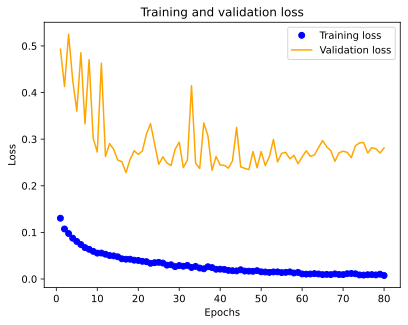

In [16]:
######## EVALUATE THE MODEL
history_dict = history.history
# training and validation loss by epoch

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

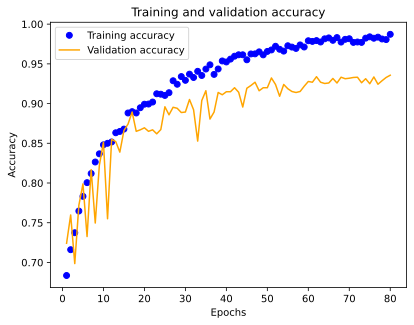

In [17]:
######## PLOT ACCURACY
# Learning curve(accuracy)
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
######## PRINT CONFUSION MATRIX AND CLASSIFICATION REPORT
a = model.predict(X_test) # prob of successes (done)
np.round(model.predict(X_test),0) # 1 and 0 (done or not)

# Round predictions to a whole number (0 or 1)
preds_tuned = np.round(model.predict(X_test),0)

#IF WE WANT TO CHANGE THRESHOLD:
#thresholded  = a > 0.117  #<-- tresholding on 0.3 value (returns boolean)   
#thresholded = thresholded.astype(int)

133/133 [==============================] - 1s 6ms/step


In [19]:
######## PROBABILITIES OF PREDICTIONS
probs_NN_3 = model.predict(X_test).ravel()

133/133 [==============================] - 1s 4ms/step


In [20]:
precision_NN_3, recall_NN_3, threshold_NN_3 = precision_recall_curve(y_test, probs_NN_3)
fscore_NN_3 = (2 * precision_NN_3 * recall_NN_3) / (precision_NN_3 + recall_NN_3)
ix_NN_3 = nanargmax(fscore_NN_3)
auc_NN_3 = auc(recall_NN_3, precision_NN_3)

In [21]:
# F1 Score and corresponding Threshold
print('Neural Network Best Threshold=%f, F-Score=%.3f' % (threshold_NN_3[ix_NN_3], fscore_NN_3[ix_NN_3]))

Neural Network Best Threshold=0.393455, F-Score=0.727


In [22]:
y_pred = (probs_NN_3 > threshold_NN_3[ix_NN_3]).astype('float')
confusion_matrix(y_test, y_pred)

array([[3591,  147],
       [ 128,  363]], dtype=int64)

In [23]:
'''# classification report
metricsNN_tuned = metrics.classification_report(y_test, preds_tuned, output_dict=True)
######## PROBABILITIES OF PREDICTIONS
probs_NN_tuned = model.predict(X_test).ravel()'''

'# classification report\nmetricsNN_tuned = metrics.classification_report(y_test, preds_tuned, output_dict=True)\n######## PROBABILITIES OF PREDICTIONS\nprobs_NN_tuned = model.predict(X_test).ravel()'

### 10d. Random Forest with Compressed data

Prepare compressed data again, exactly same as the other notebook

In [24]:
### 1. CHOOSE RANGE OF COLUMNS TO APPLY THE TRANSFORMATION
# [:, 1:28] : VESSELS
# [:, 28:42] : MAINTENANCE KITS
# [:, 42:51] : CYLINDERS
# [:, 51:58] : YEARS


### 2. We choose attributes describing the vessel
# Separate the parts on which we will erform LLE
# In train
X_train_2 = X_train.drop(X_train.iloc[:, np.r_[1:28, 42:51]],axis = 1)
X_train_lle_vess = X_train.iloc[:, np.r_[1:28, 42:51] ]   

# In test
X_test_2 = X_test.drop(X_test.iloc[:, np.r_[1:28, 42:51]],axis = 1)
X_test_lle_vess = X_test.iloc[:, np.r_[1:28, 42:51] ]

In [25]:
### 2. PERFORM LLE TO X_TRAIN_LLE_PART
lle = LocallyLinearEmbedding(n_neighbors=30, n_components = 4)  # , method= 'modified'
# n_neighbors must be higher than n_components when method='modified'
# eigen_solver='dense' should be avoided for large problems
# eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved.

lle.fit(X_train_lle_vess)

X_train_lle_vess = lle.transform(X_train_lle_vess)
X_train_lle_vess = pd.DataFrame(X_train_lle_vess)

X_test_lle_vess = lle.transform(X_test_lle_vess)
X_test_lle_vess = pd.DataFrame(X_test_lle_vess)

In [26]:
### 4. MERGE DATASETS AGAIN
X_train_lle_vess = X_train_lle_vess.join(X_train_2)
X_test_lle_vess = X_test_lle_vess.join(X_test_2)

In [27]:
X_train_lle_vess[0] = StandardScaler().fit_transform(np.array(X_train_lle_vess[0]).reshape(-1,1))
X_train_lle_vess[1] = StandardScaler().fit_transform(np.array(X_train_lle_vess[1]).reshape(-1,1))
X_train_lle_vess[2] = StandardScaler().fit_transform(np.array(X_train_lle_vess[2]).reshape(-1,1))
X_train_lle_vess[3] = StandardScaler().fit_transform(np.array(X_train_lle_vess[3]).reshape(-1,1))

In [28]:
X_test_lle_vess[0] = StandardScaler().fit_transform(np.array(X_test_lle_vess[0]).reshape(-1,1))
X_test_lle_vess[1] = StandardScaler().fit_transform(np.array(X_test_lle_vess[1]).reshape(-1,1))
X_test_lle_vess[2] = StandardScaler().fit_transform(np.array(X_test_lle_vess[2]).reshape(-1,1))
X_test_lle_vess[3] = StandardScaler().fit_transform(np.array(X_test_lle_vess[3]).reshape(-1,1))

In [35]:
### 1. USE GRIDSEARCH TO FIND BEST PARAMETERS FOR RANDOM FOREST (LLE)
# define models and parameters
model = RandomForestClassifier(class_weight = 'balanced')
n_estimators = [500, 1000, 1200]   # default: 100, previous try 500
max_features = ['sqrt', 'log2', None]   # default: sqrt
min_samples_leaf = [1]     # default: 1    # [, 3,  5]  give much worse results
criterion = ['gini', 'entropy']   # default: gini
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features, min_samples_leaf = min_samples_leaf, criterion=criterion)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_lle_vess, y_train)
# summarize results
print("Best f1 score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best f1 score: 0.644733 using {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 1200}
0.640245 (0.031388) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
0.641037 (0.029032) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}
0.641945 (0.029017) with: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1200}
0.640188 (0.030086) with: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 500}
0.641753 (0.028568) with: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 1000}
0.641004 (0.028652) with: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 1200}
0.642014 (0.029881) with: {'criterion': 'gini', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 500}
0.643878 (0.028583) with: {'criterion': 'gini', 'max_features': 

In [29]:
### 2. USE BEST PARAMETERS TO MAKE PREDICTIONS ON THE TEST SET 
#Best f1 score: 0.680700 using {'criterion': 'entropy', 'max_features':None, 'min_samples_leaf': 1, 'n_estimators': 1200}
RFC_LLE_3 = RandomForestClassifier(n_estimators=1200, max_features=None, min_samples_leaf = 1, criterion='entropy', class_weight = 'balanced')   # class_weight = {0:0.15, 1: 0.85} doesn't make difference
RFC_LLE_3.fit(X_train_lle_vess,y_train)
y_pred_RFC_LLE_3 = RFC_LLE_3.predict(X_test_lle_vess)
probs_RFC_LLE_3 = RFC_LLE_3.predict_proba(X_test_lle_vess)

ScoreRFC_LLE_3 = metrics.f1_score(y_test, y_pred_RFC_LLE_3)  #doesn't change with f1_score / recall_score
cmRFC_LLE_3 = metrics.confusion_matrix(y_test, y_pred_RFC_LLE_3)
metricsRFC_LLE_3 = metrics.classification_report(y_test, y_pred_RFC_LLE_3)

In [30]:
probs_RFC_LLE_3 = probs_RFC_LLE_3[:, 1]

In [31]:
precision_RFC_LLE_3, recall_RFC_LLE_3, threshold_RFC_LLE_3 = precision_recall_curve(y_test, probs_RFC_LLE_3)
fscore_RFC_LLE_3 = (2 * precision_RFC_LLE_3 * recall_RFC_LLE_3) / (precision_RFC_LLE_3 + recall_RFC_LLE_3)
ix_RFC_LLE_3 = nanargmax(fscore_RFC_LLE_3)
auc_RFC_LLE_3 = auc(recall_RFC_LLE_3, precision_RFC_LLE_3)

In [32]:
# F1 Score and corresponding Threshold
print('Random Forest (LLE) with weighted classes Best Threshold=%f, F-Score=%.3f' % (threshold_RFC_LLE_3[ix_RFC_LLE_3], fscore_RFC_LLE_3[ix_RFC_LLE_3]))

Random Forest (LLE) with weighted classes Best Threshold=0.663041, F-Score=0.630


In [33]:
y_pred = (probs_RFC_LLE_3 > threshold_RFC_LLE_3[ix_RFC_LLE_3]).astype('float')
confusion_matrix(y_test, y_pred)

array([[3549,  189],
       [ 182,  309]], dtype=int64)

## 10. Compare tuned models

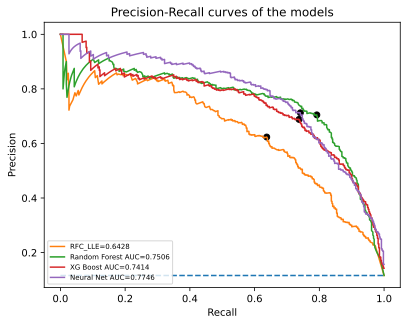

In [34]:
### 6. PLOT PRECISION-RECALL CURVES
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.title("Precision-Recall curves of the models")
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

plt.plot(recall_RFC_LLE_3, precision_RFC_LLE_3, label='RFC_LLE='+str("%.4f" % auc_RFC_LLE_3))
plt.plot(recall_RFC_3, precision_RFC_3, label='Random Forest AUC='+str("%.4f" % auc_RFC_3))
plt.plot(recall_XGB_3, precision_XGB_3, label='XG Boost AUC='+str("%.4f" % auc_XGB_3))
plt.plot(recall_NN_3, precision_NN_3, label='Neural Net AUC='+str("%.4f" % auc_NN_3))

plt.scatter(recall_RFC_LLE_3[ix_RFC_LLE_3], precision_RFC_LLE_3[ix_RFC_LLE_3], marker='o', color='black')
plt.scatter(recall_RFC_3[ix_RFC_3], precision_RFC_3[ix_RFC_3], marker='o', color='black')
plt.scatter(recall_XGB_3[ix_XGB_3], precision_XGB_3[ix_XGB_3], marker='o', color='black')
plt.scatter(recall_NN_3[ix_NN_3], precision_NN_3[ix_NN_3], marker='o', color='black')


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(loc = 3, prop={'size': 7})
# show the plot
plt.show()

In [35]:
print('Random Forest Best Threshold=%f, F-Score=%.3f' % (threshold_RFC_3[ix_RFC_3], fscore_RFC_3[ix_RFC_3]))
print('XG Boost Best Threshold=%f, F-Score=%.3f' % (threshold_XGB_3[ix_XGB_3], fscore_XGB_3[ix_XGB_3]))
print('Neural Network Best Threshold=%f, F-Score=%.3f' % (threshold_NN_3[ix_NN_3], fscore_NN_3[ix_NN_3]))
print('Compressed Random Forest Best Threshold=%f, F-Score=%.3f' % (threshold_RFC_LLE_3[ix_RFC_LLE_3], fscore_RFC_LLE_3[ix_RFC_LLE_3]))

Random Forest Best Threshold=0.378000, F-Score=0.746
XG Boost Best Threshold=0.572478, F-Score=0.712
Neural Network Best Threshold=0.393455, F-Score=0.727
Compressed Random Forest Best Threshold=0.663041, F-Score=0.630


In [36]:
results = [['Random Forest', fscore_RFC_3[ix_RFC_3]],
           ['XG Boost', fscore_XGB_3[ix_XGB_3]],
           ['Neural Network', fscore_NN_3[ix_NN_3]],
           ['Random Forest with LLE', fscore_RFC_LLE_3[ix_RFC_LLE_3]]]

Total_Scores = pd.DataFrame(results, columns=['Classifier', 'F1 Score'])
Total_Scores

Classifier  F1 Score
0           Random Forest  0.745925
1                XG Boost  0.711898
2          Neural Network  0.726547
3  Random Forest with LLE  0.630413

Final f scores are improved, a well as the Neural network's Threshold (slightly). Should spend more time on tuning (especially NN) since some hyperparameters are selected closer to the limit of the intervals

PLease continue to notebook 4_test_2021.ipynb